In [1]:
import torch.optim as optim
from functions import overlapScore
from torch.utils.data import DataLoader
from cnn_model import *
from training_dataset import *

def train_model(net, dataloader, batchSize, lr_rate):
    criterion = nn.MSELoss()
    optimization = optim.SGD(net.parameters(), lr=lr_rate)

    # Check if CUDA is available
    if torch.cuda.is_available():
        net.cuda()

    for epoch in range(30):

        for i, data in enumerate(dataloader):
            optimization.zero_grad()

            inputs, labels = data

            # Move inputs and labels to the GPU if available
            if torch.cuda.is_available():
                inputs = inputs.cuda()
                labels = labels.cuda()

            inputs, labels = inputs.view(batchSize, 1, 100, 100), labels.view(batchSize, 4)

            outputs = net(inputs)

            loss = criterion(outputs, labels)
            loss.backward()
            optimization.step()

            pbox = outputs.detach().cpu().numpy()  # Move back to CPU for numpy operations
            gbox = labels.detach().cpu().numpy()
            score, _ = overlapScore(pbox, gbox)

            print('[epoch %5d, step: %d, loss: %f, Average Score = %f' % (epoch+1, i+1, loss.item(), score/batchSize))

    print('Finish Training')

if __name__ == '__main__':
    # Hyperparameters
    learning_rate = 0.1
    batch = 100
    no_of_workers = 2
    shuffle = True

    trainingdataset = training_dataset()
    dataLoader = DataLoader(
        dataset=trainingdataset,
        batch_size=batch,
        shuffle=shuffle,
        num_workers=no_of_workers
    )

    model = cnn_model()
    model.train()

    train_model(model, dataLoader, batch, learning_rate)
    torch.save(model.state_dict(), './Model/cnn_model.pth')

[epoch     1, step: 1, loss: 0.211481, Average Score = 0.000000
[epoch     1, step: 2, loss: 0.040240, Average Score = 0.077564
[epoch     1, step: 3, loss: 0.236522, Average Score = 0.004531
[epoch     1, step: 4, loss: 0.204110, Average Score = 0.000000
[epoch     1, step: 5, loss: 0.175740, Average Score = 0.000000
[epoch     1, step: 6, loss: 0.158142, Average Score = 0.000000
[epoch     1, step: 7, loss: 0.142486, Average Score = 0.000000
[epoch     1, step: 8, loss: 0.124274, Average Score = 0.000000
[epoch     1, step: 9, loss: 0.102660, Average Score = 0.000000
[epoch     1, step: 10, loss: 0.083747, Average Score = 0.000245
[epoch     2, step: 1, loss: 0.059140, Average Score = 0.010413
[epoch     2, step: 2, loss: 0.022911, Average Score = 0.176962
[epoch     2, step: 3, loss: 0.009057, Average Score = 0.449652
[epoch     2, step: 4, loss: 0.008773, Average Score = 0.442141
[epoch     2, step: 5, loss: 0.007781, Average Score = 0.475863
[epoch     2, step: 6, loss: 0.008029, 

Test Average overlap score : 0.523101


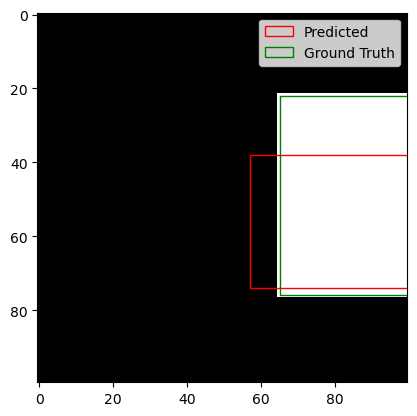

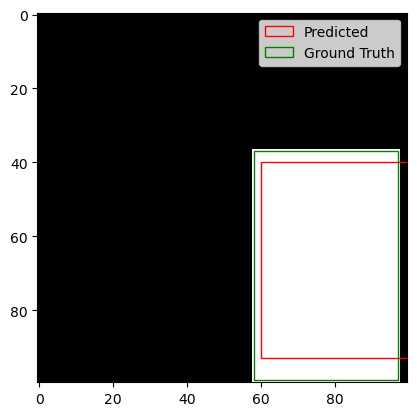

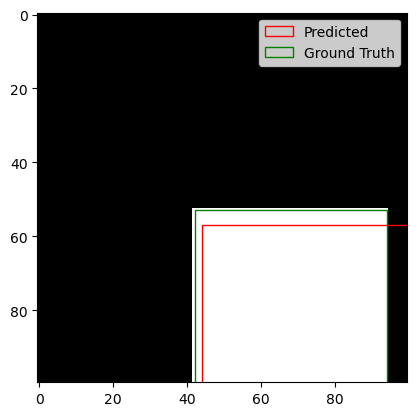

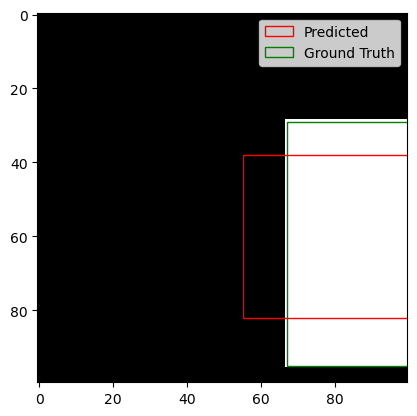

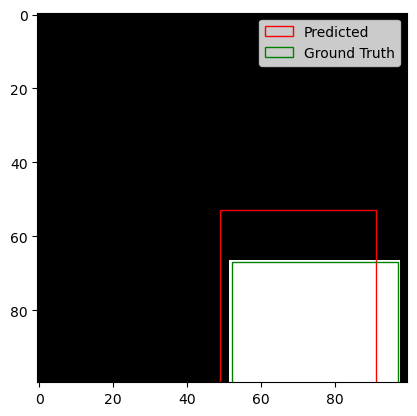

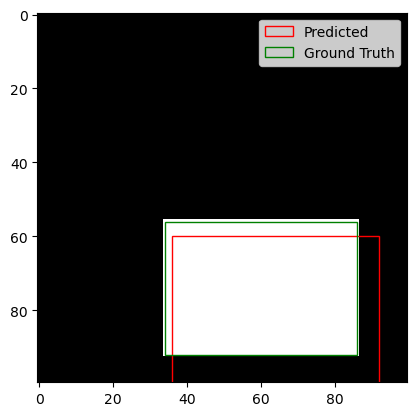

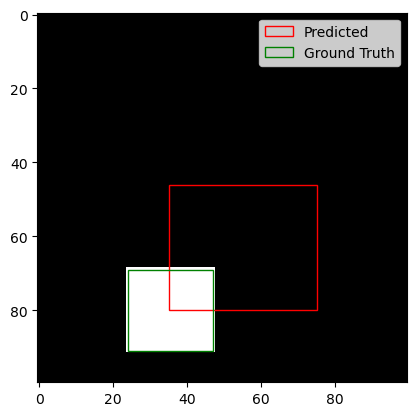

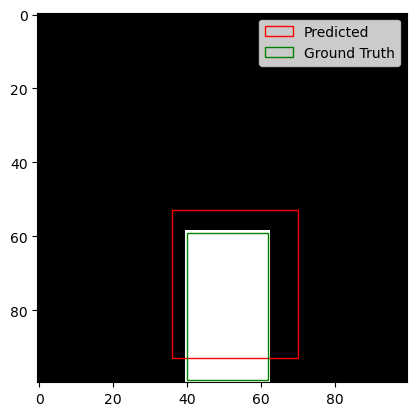

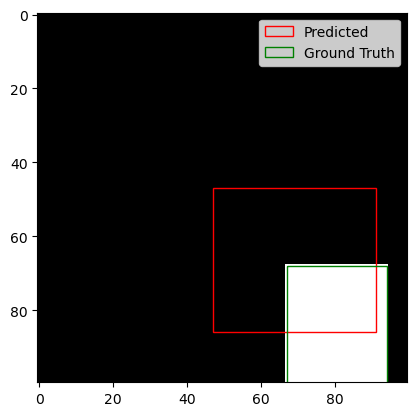

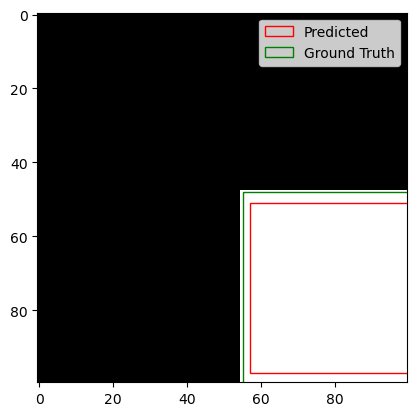

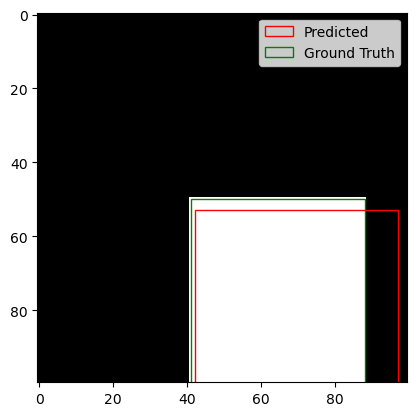

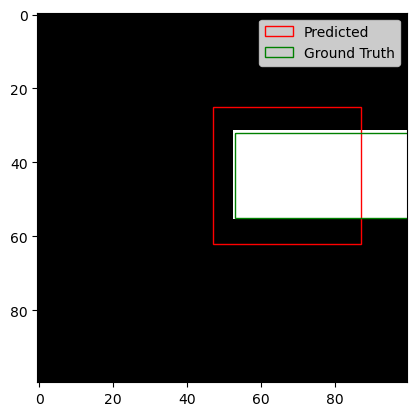

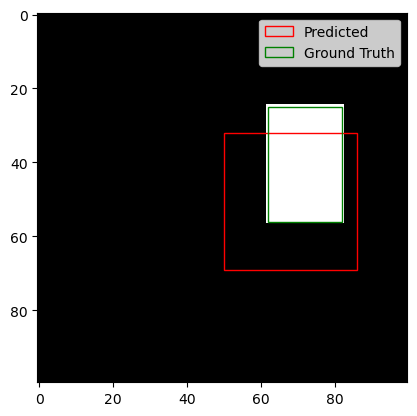

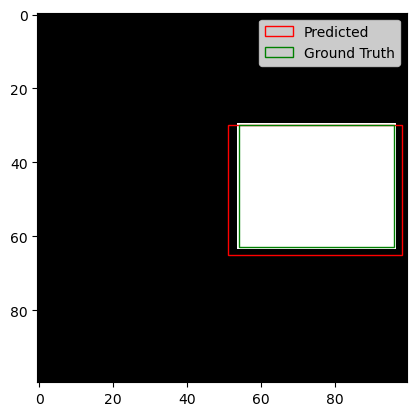

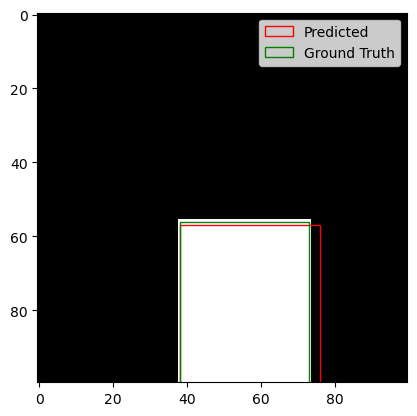

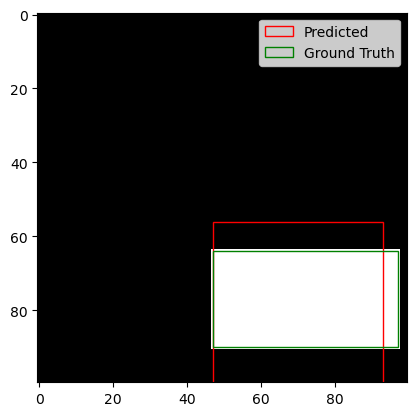

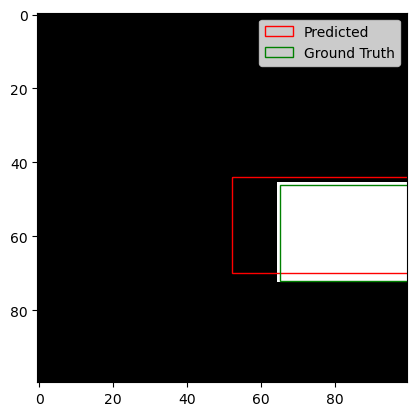

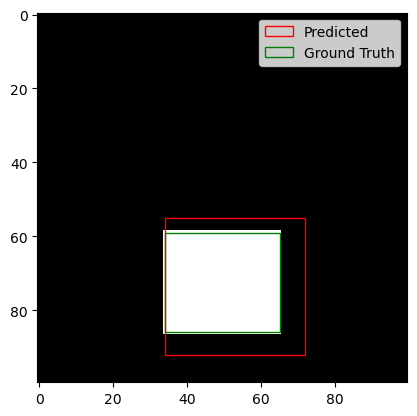

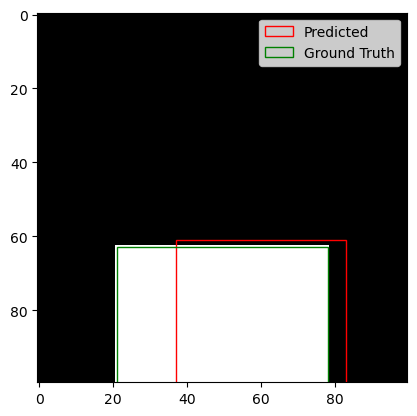

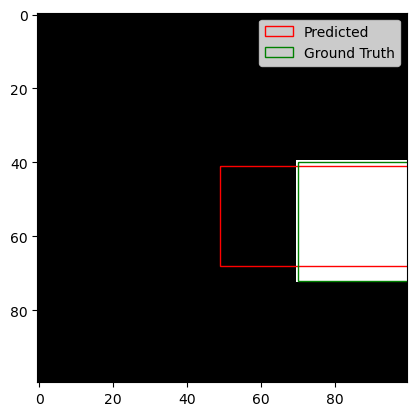

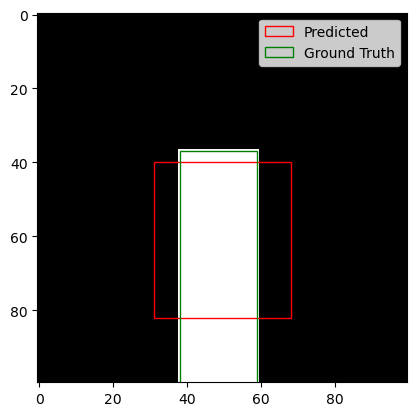

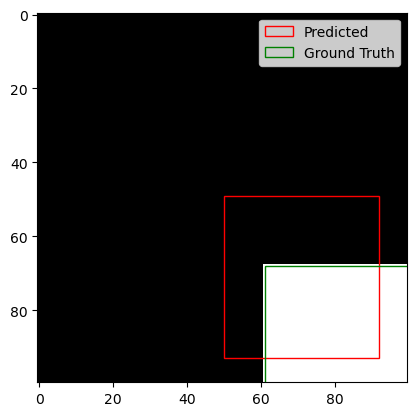

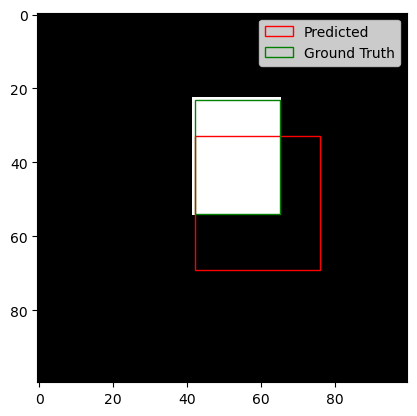

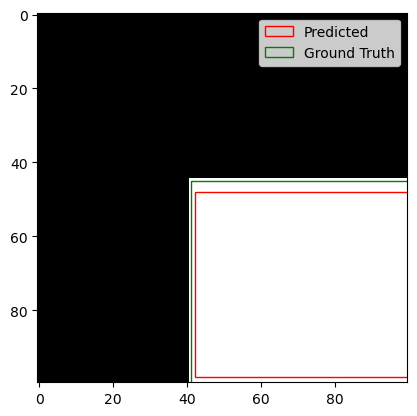

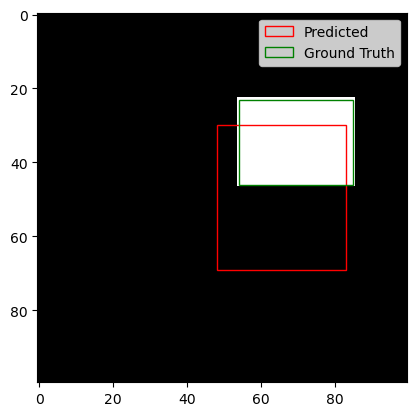

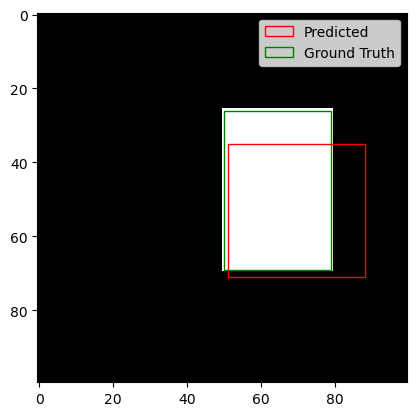

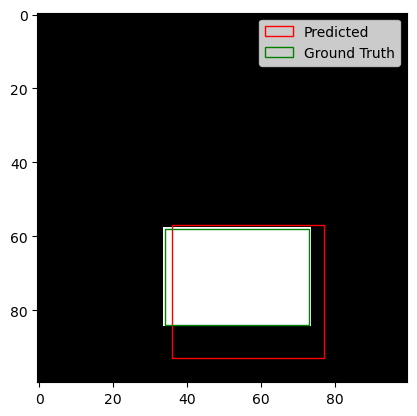

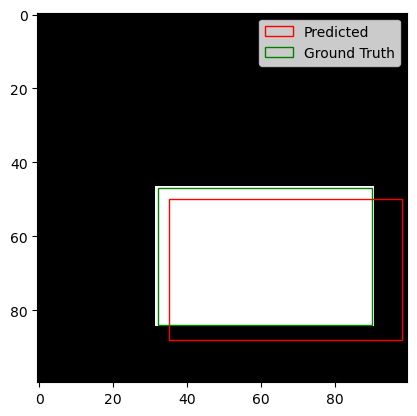

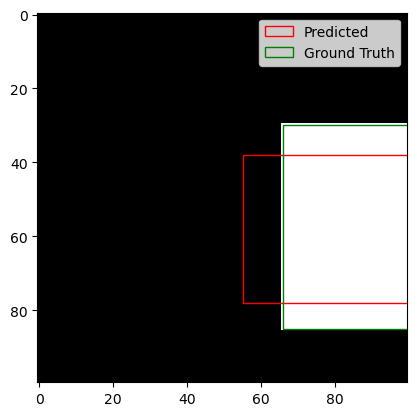

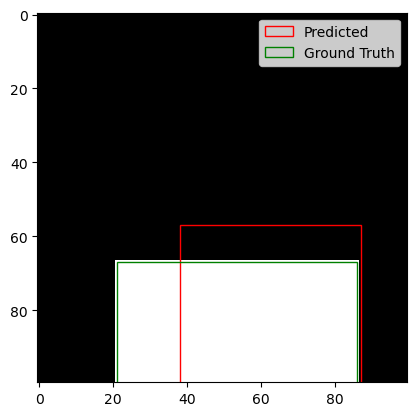

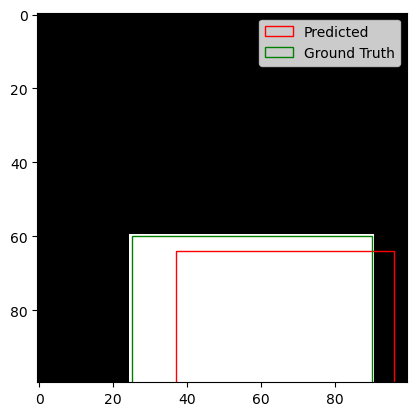

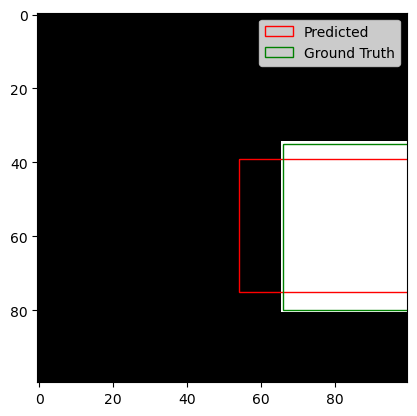

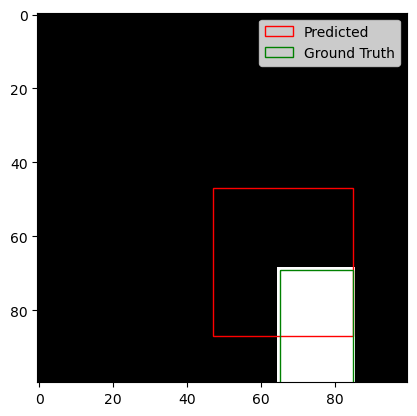

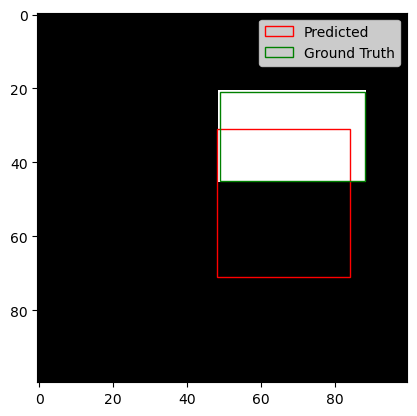

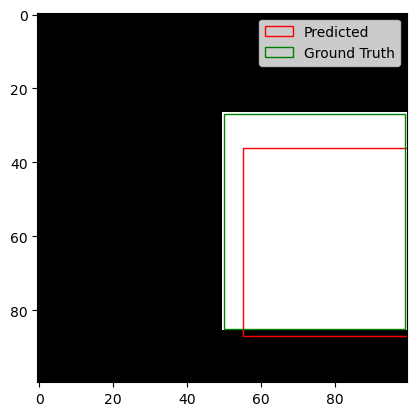

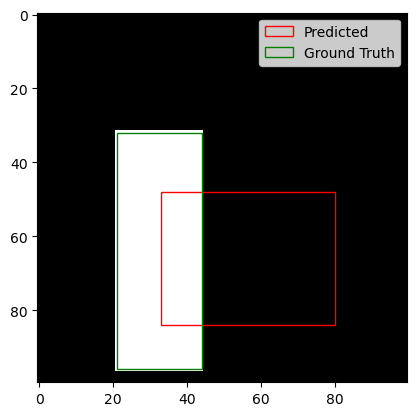

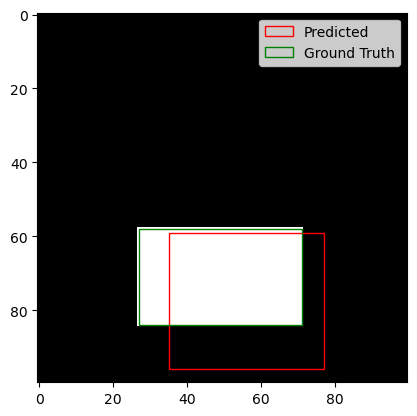

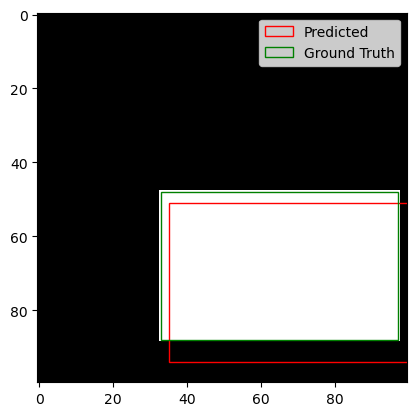

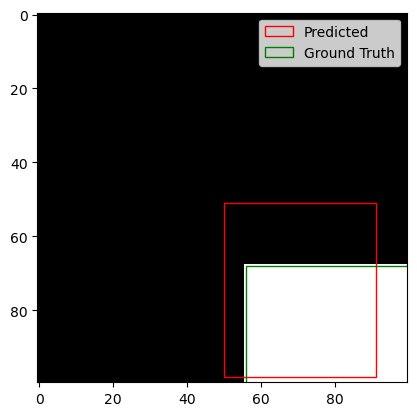

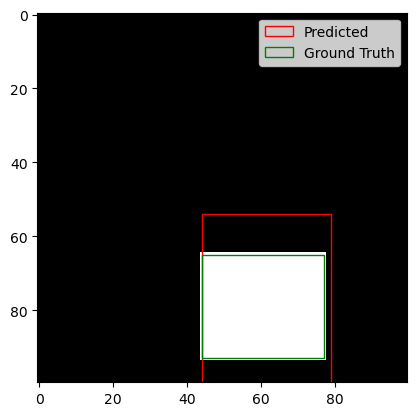

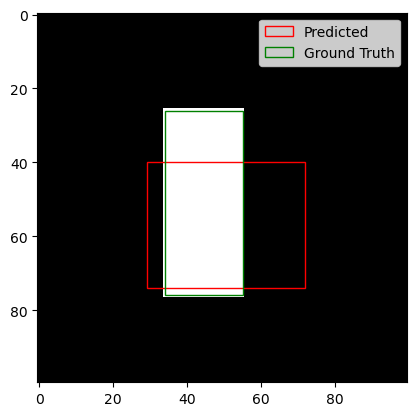

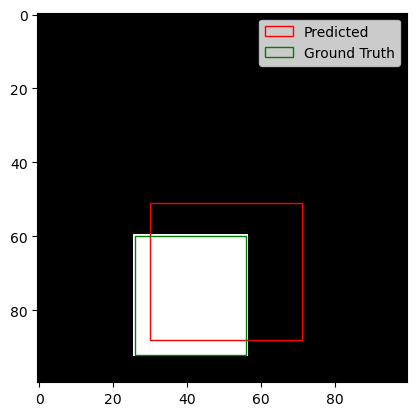

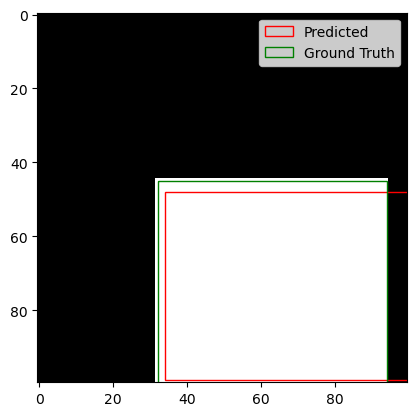

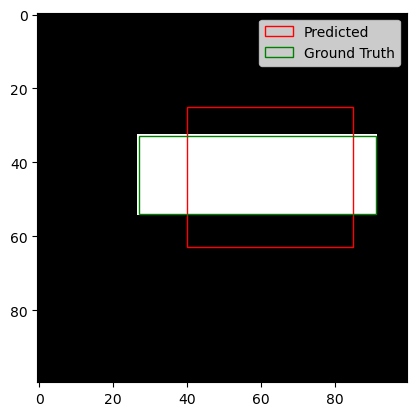

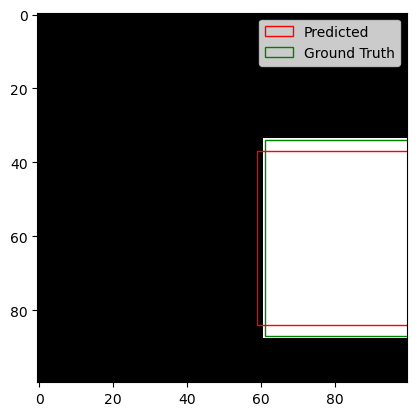

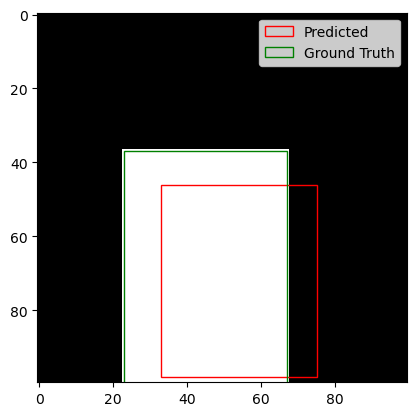

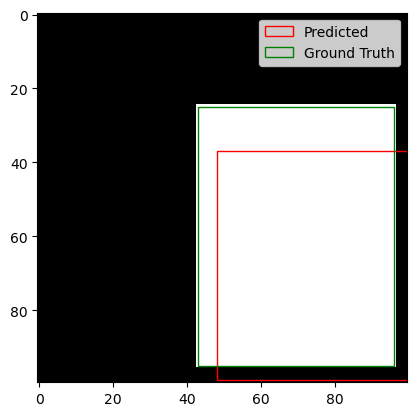

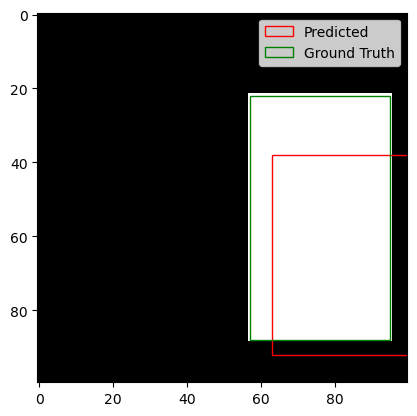

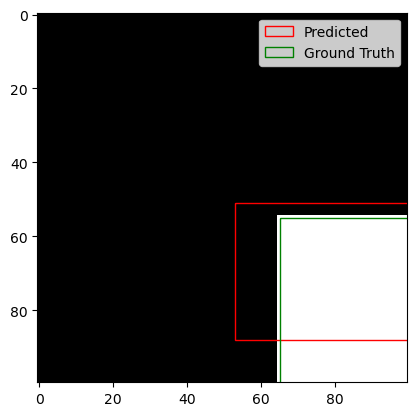

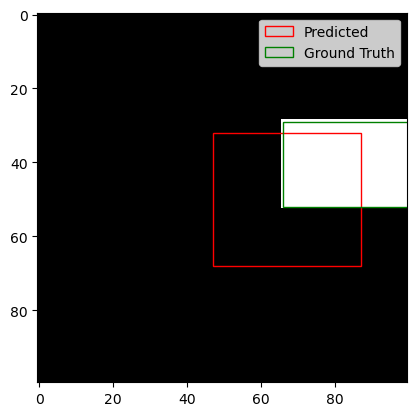

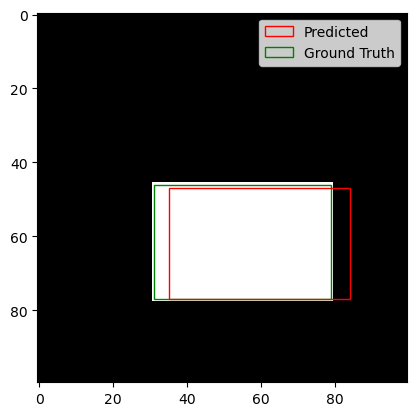

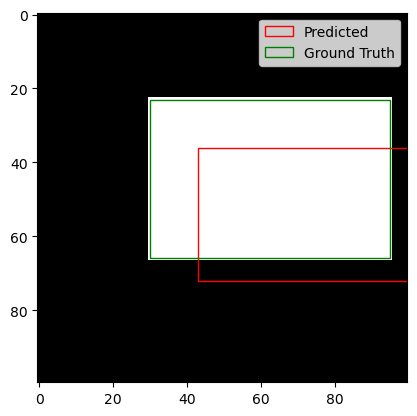

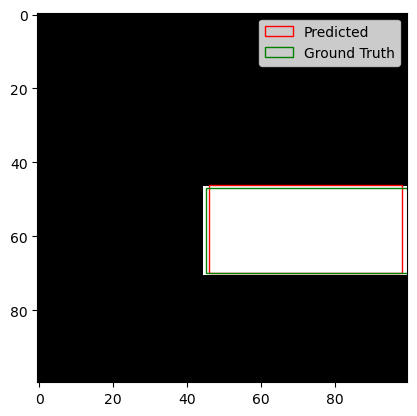

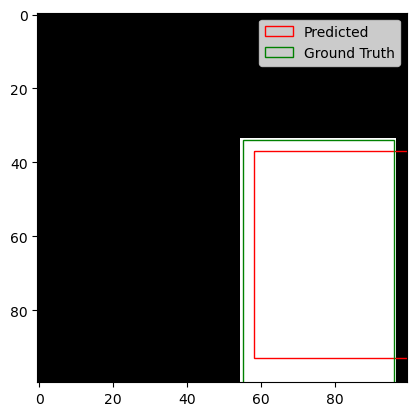

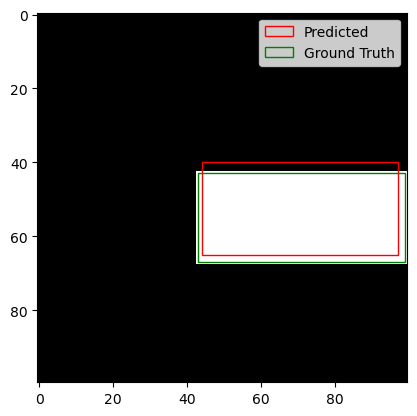

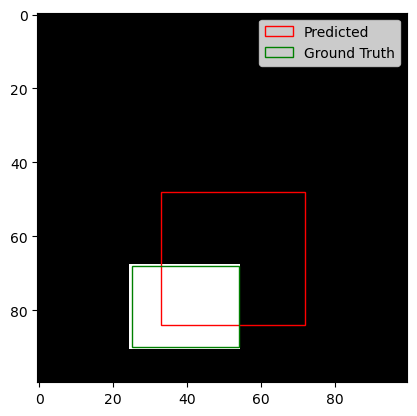

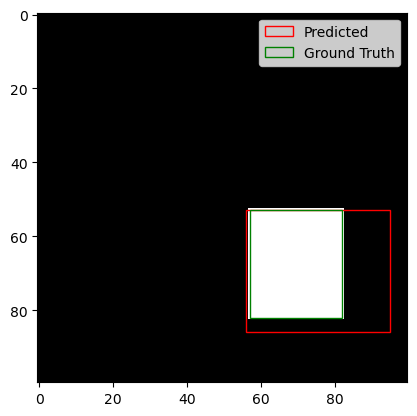

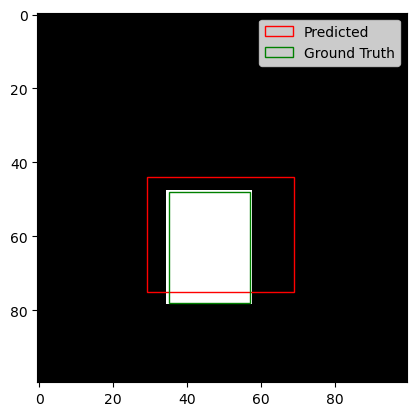

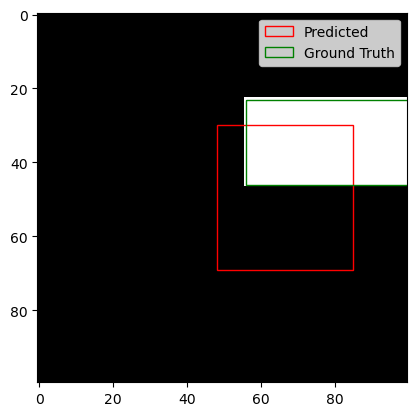

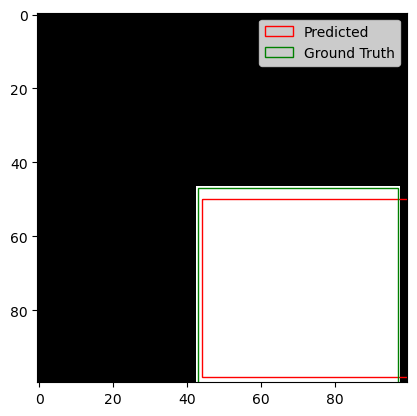

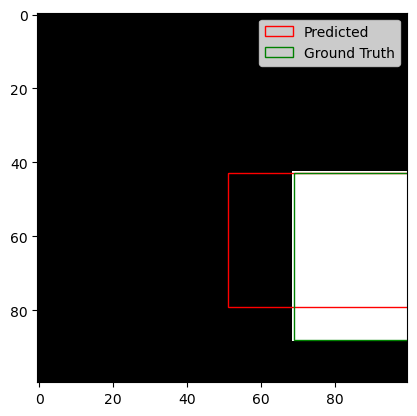

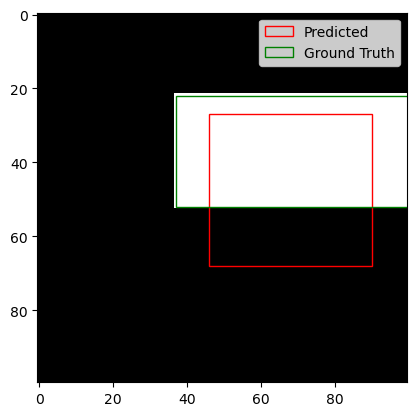

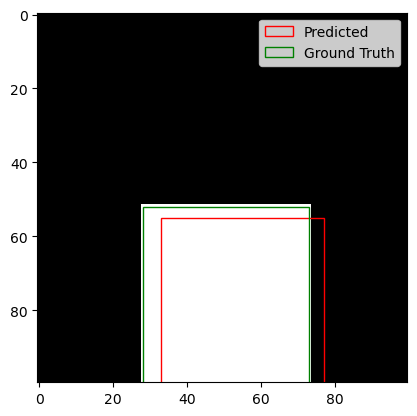

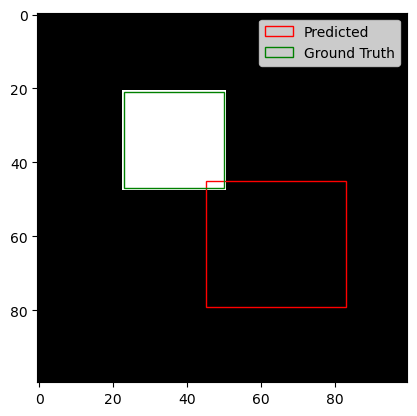

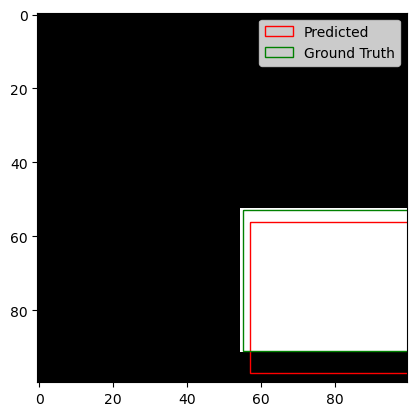

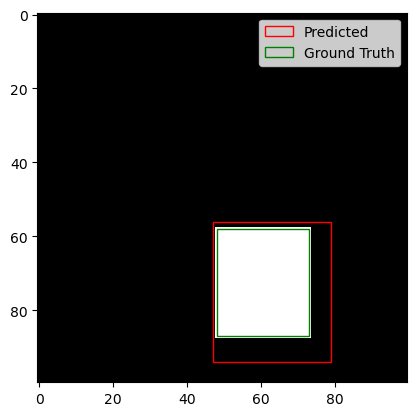

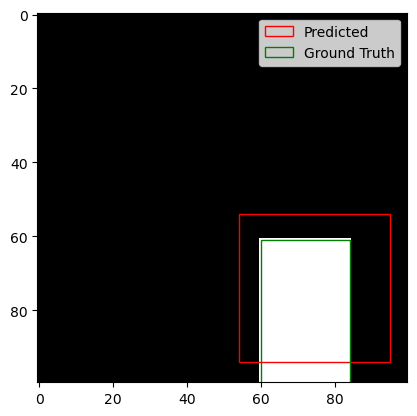

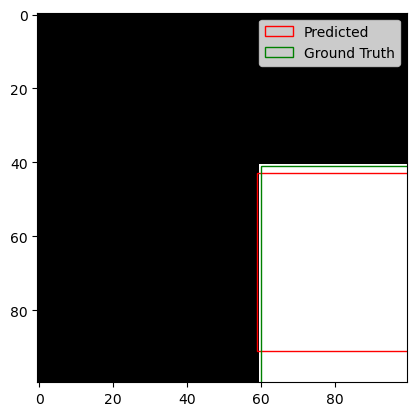

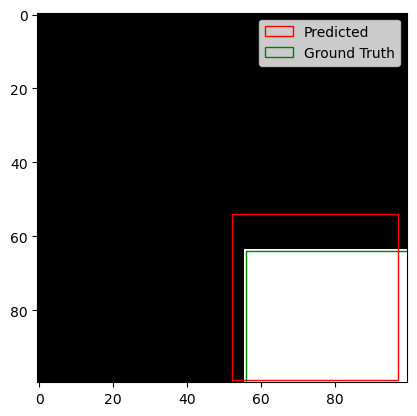

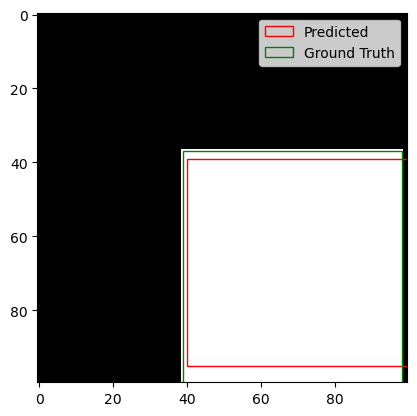

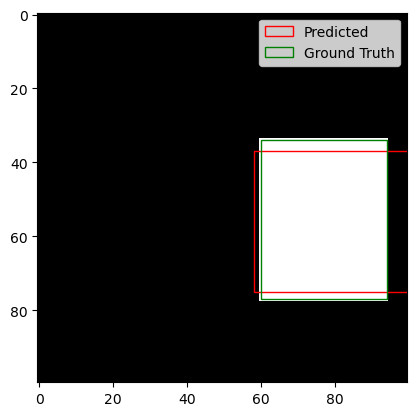

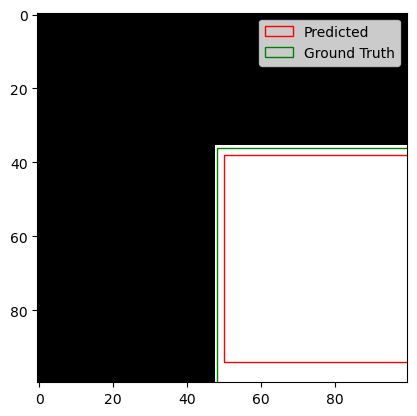

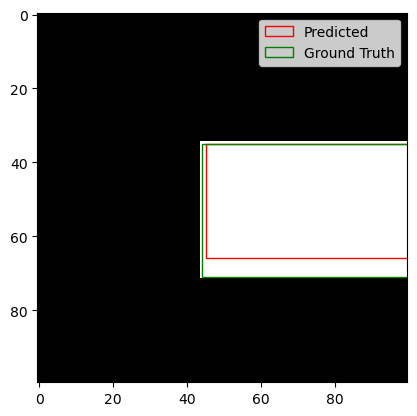

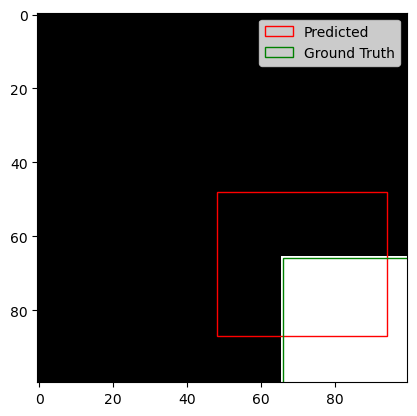

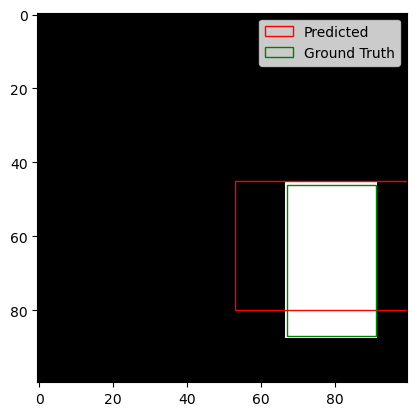

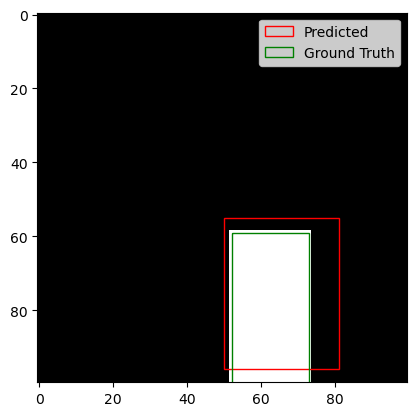

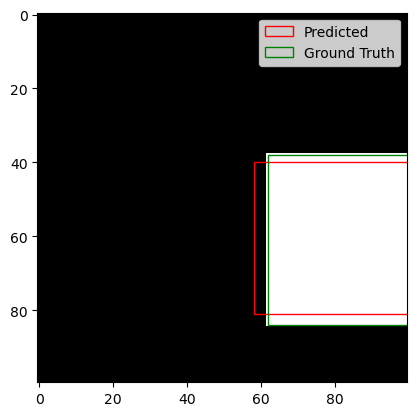

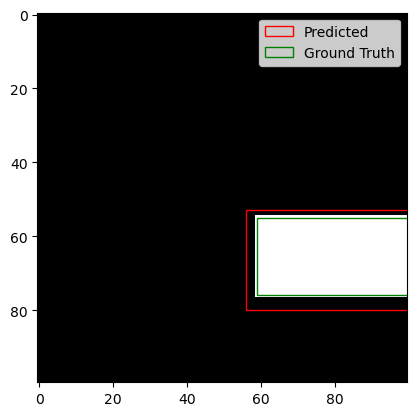

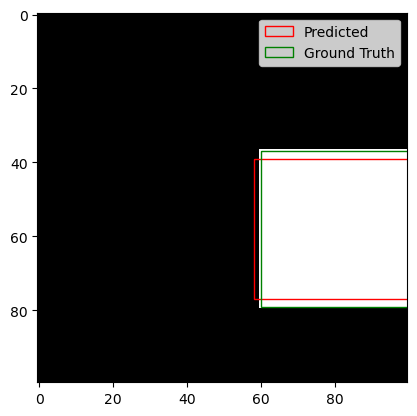

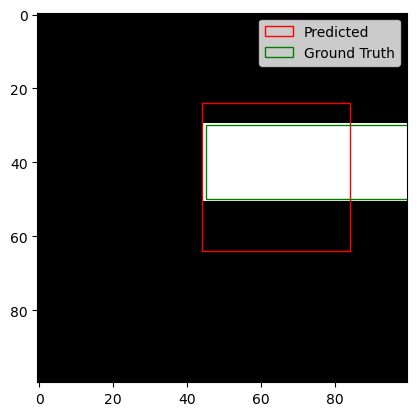

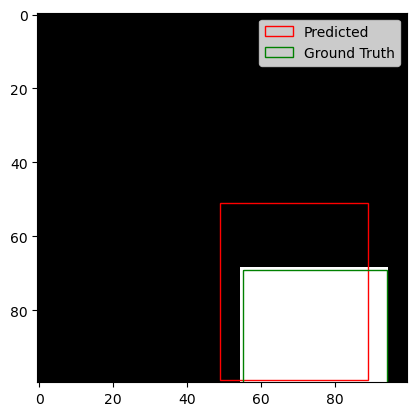

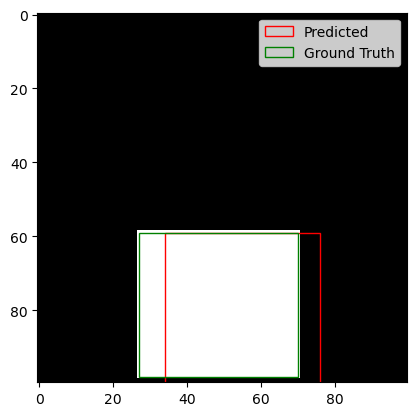

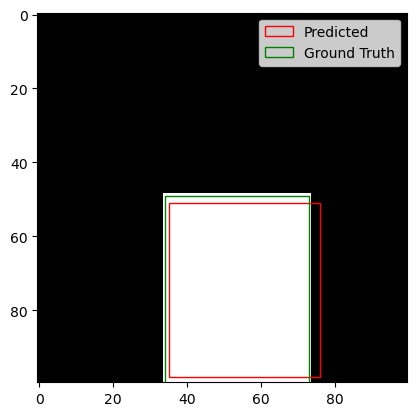

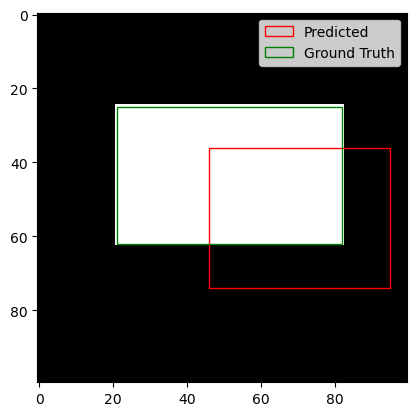

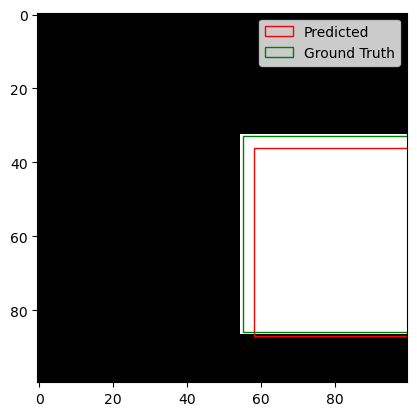

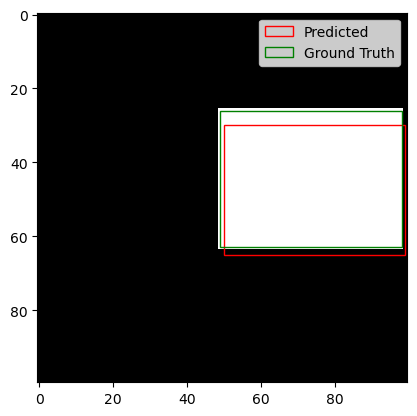

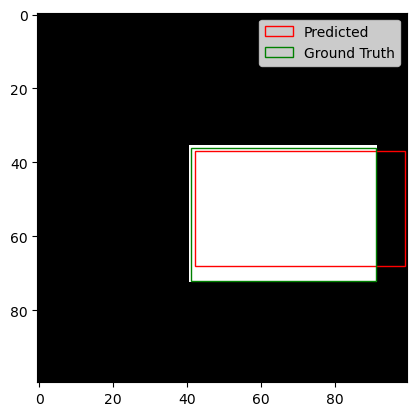

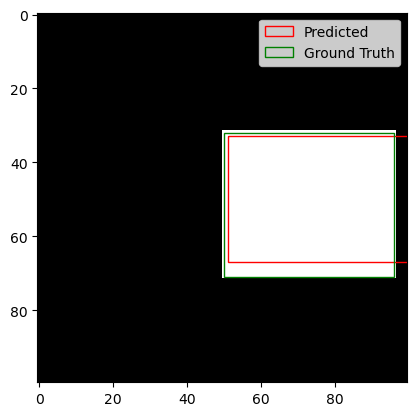

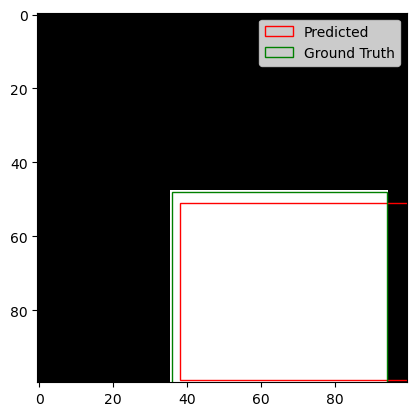

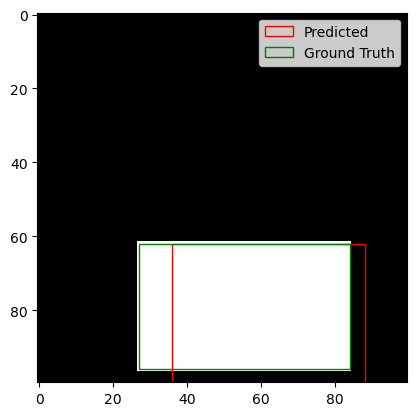

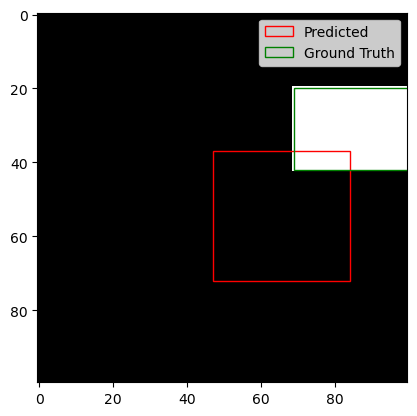

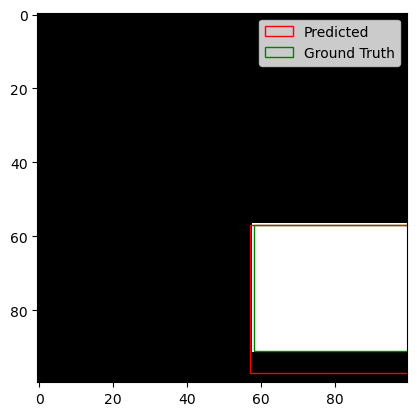

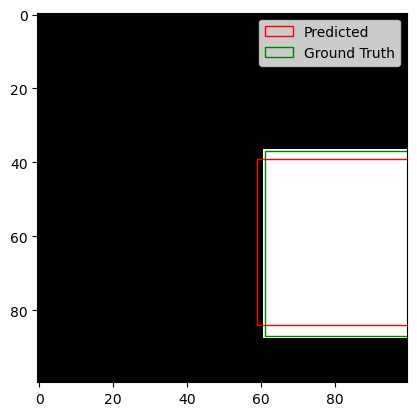

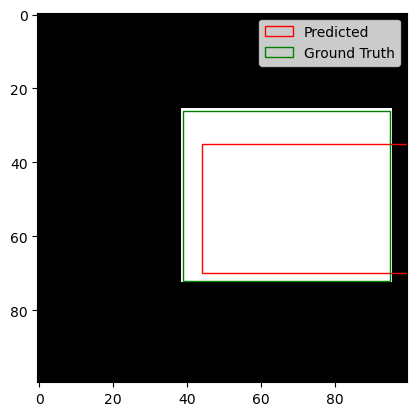

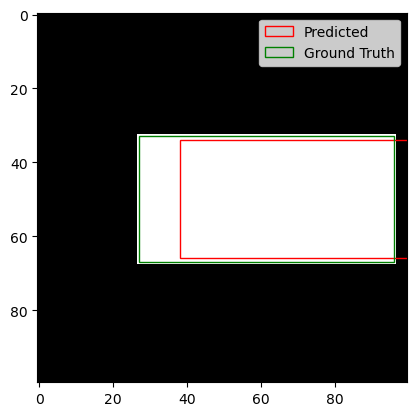

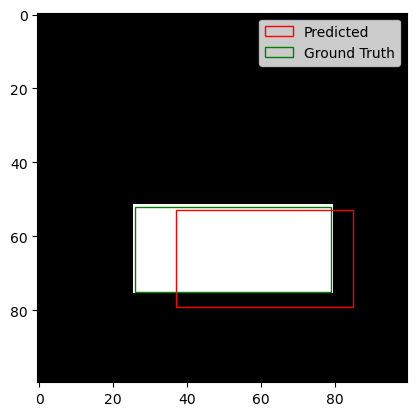

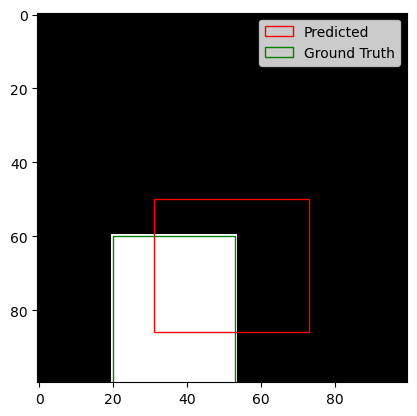

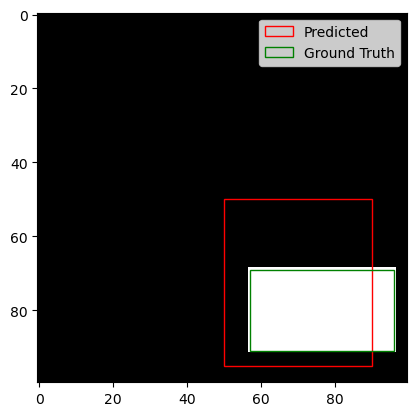

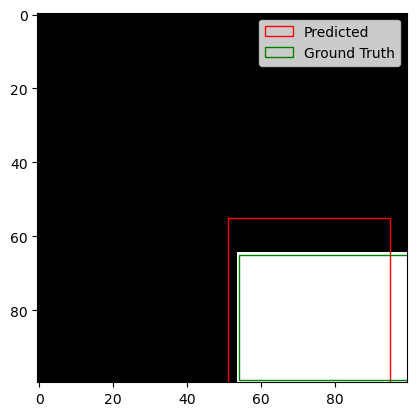

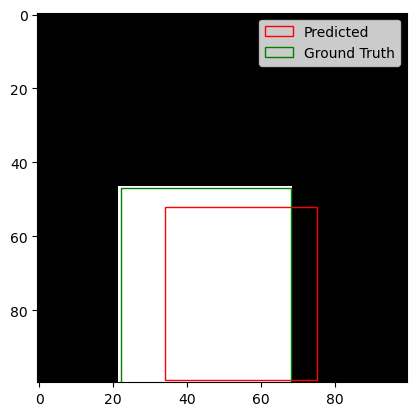

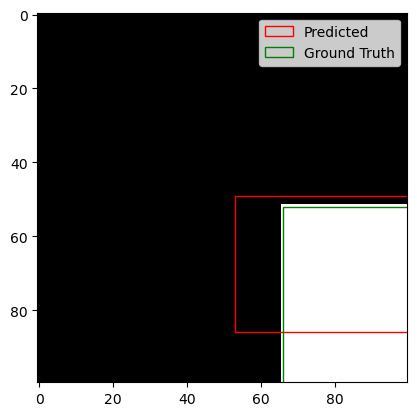

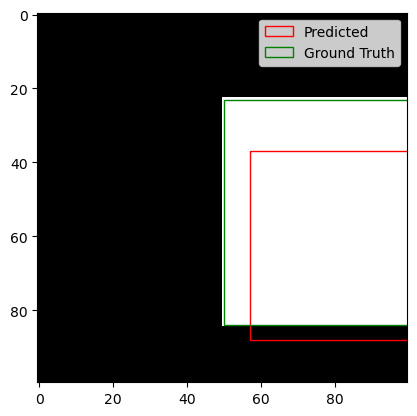

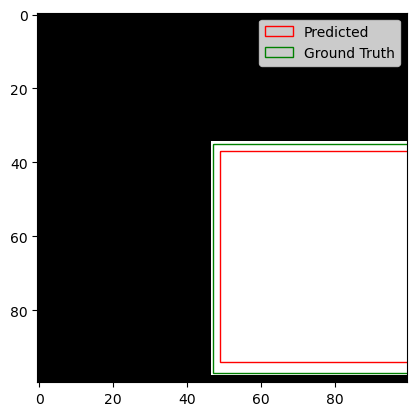

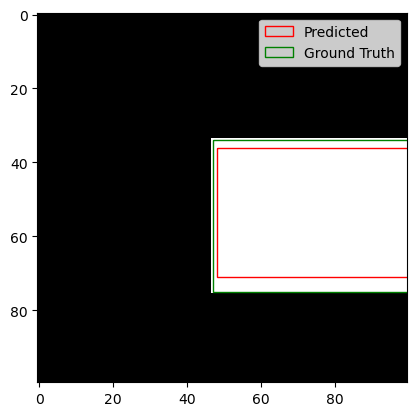

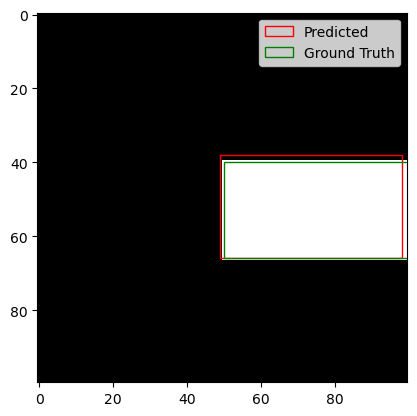

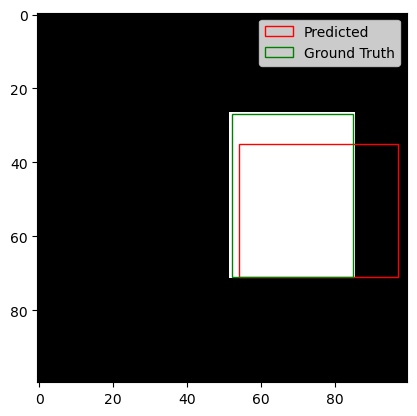

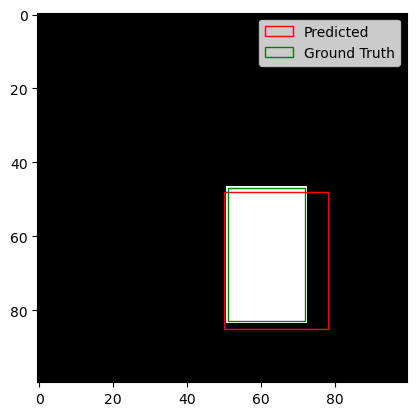

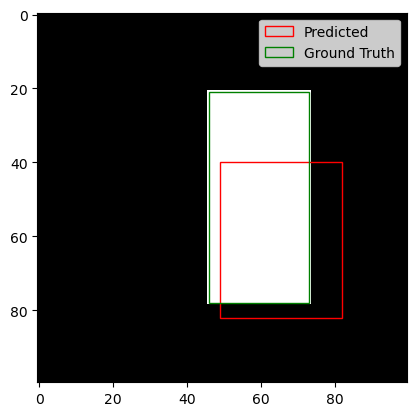

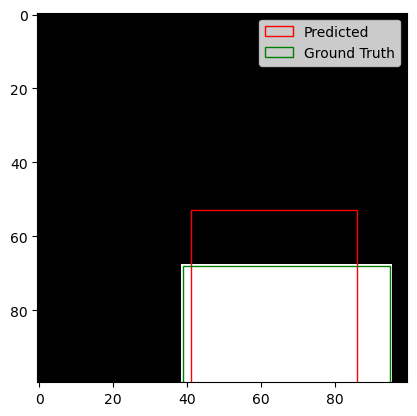

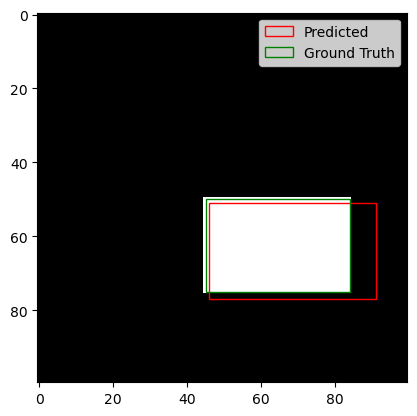

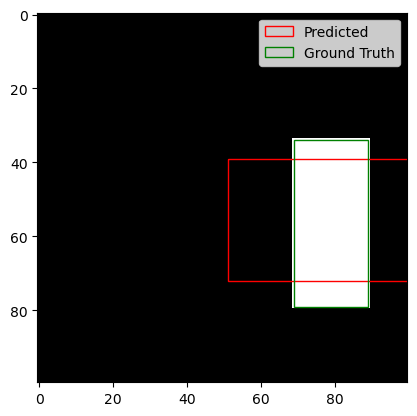

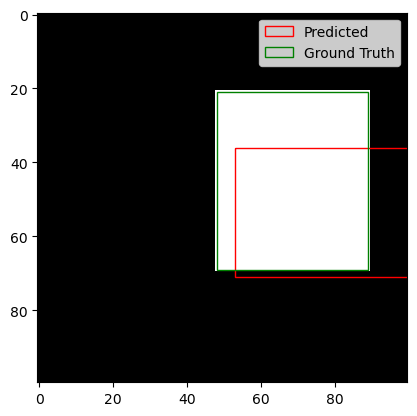

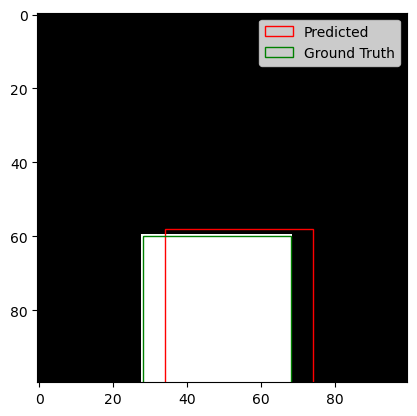

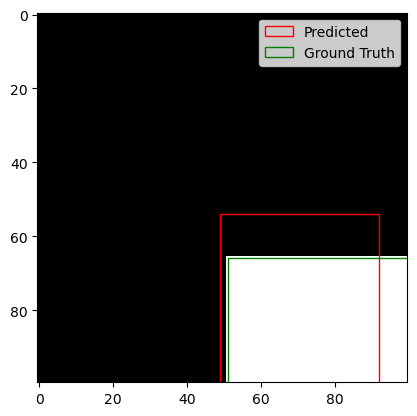

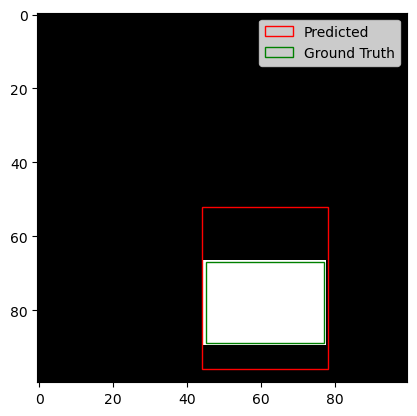

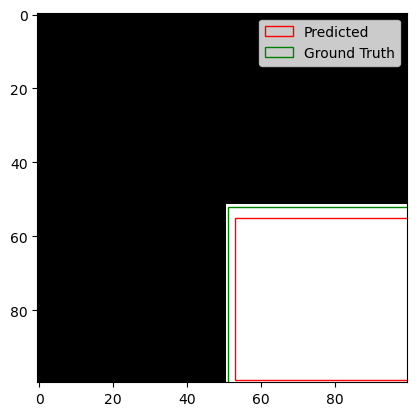

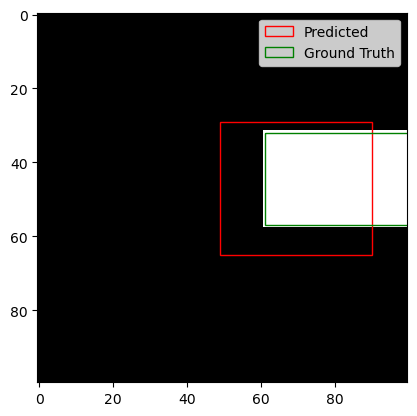

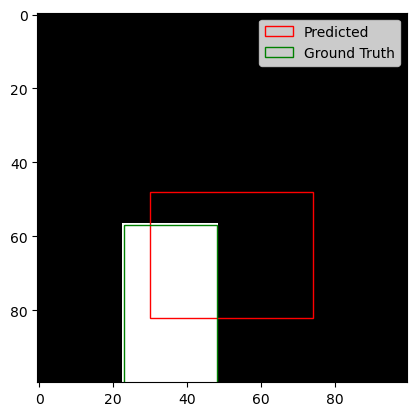

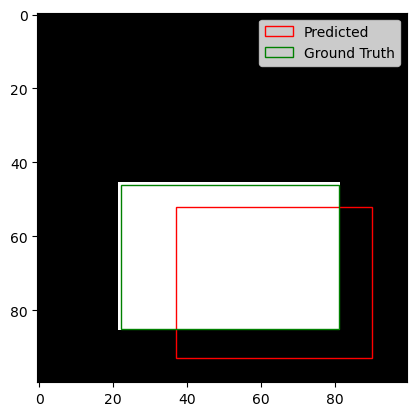

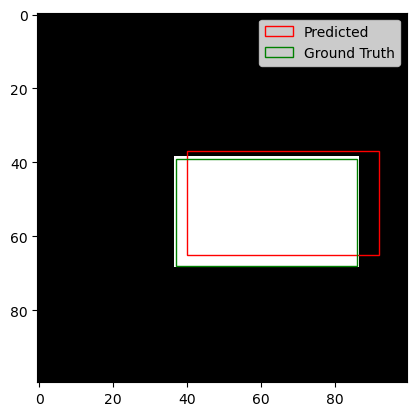

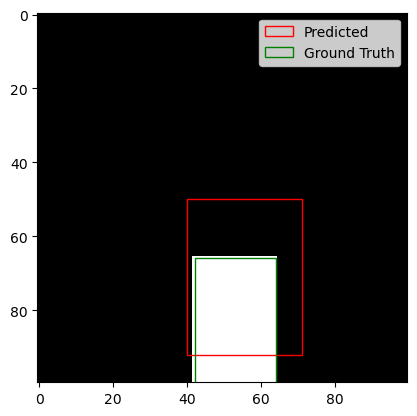

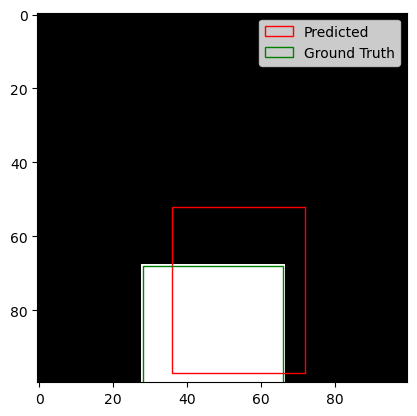

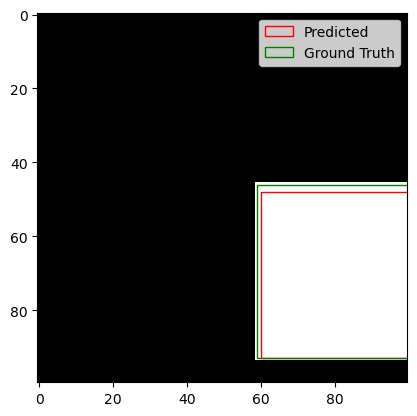

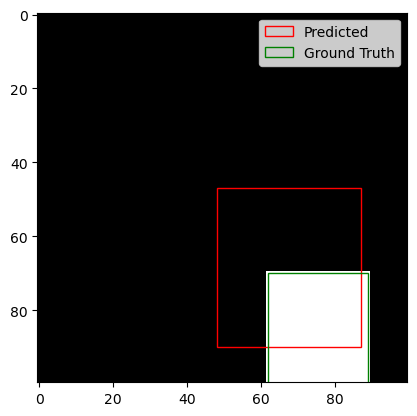

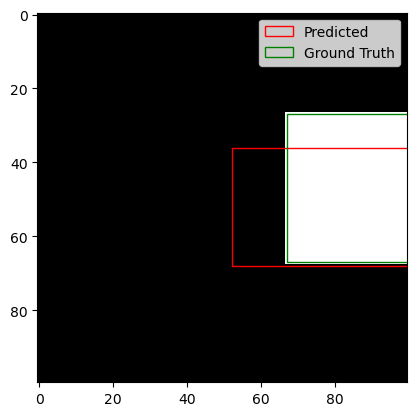

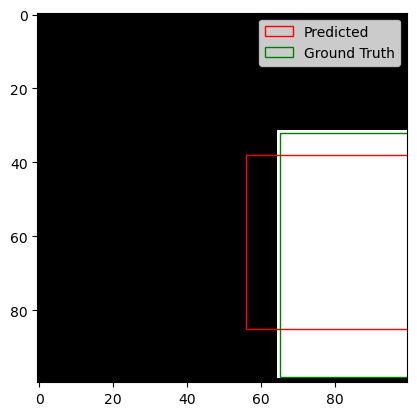

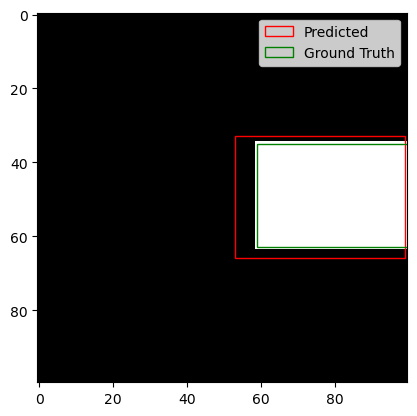

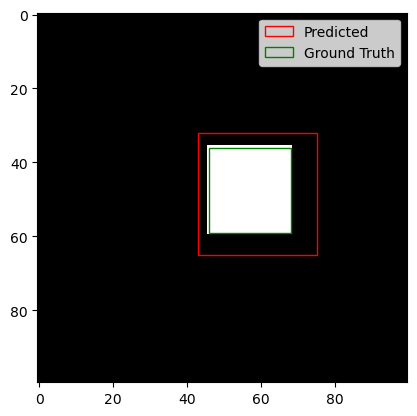

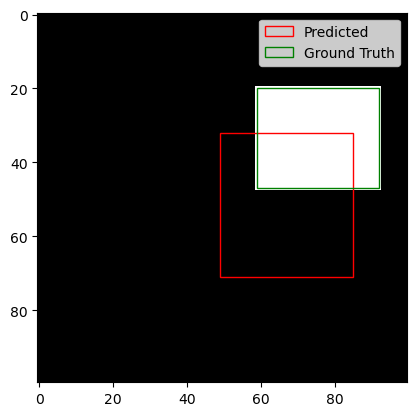

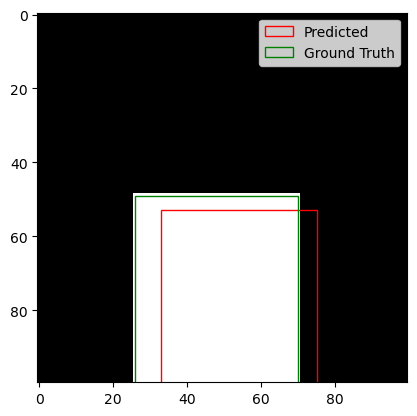

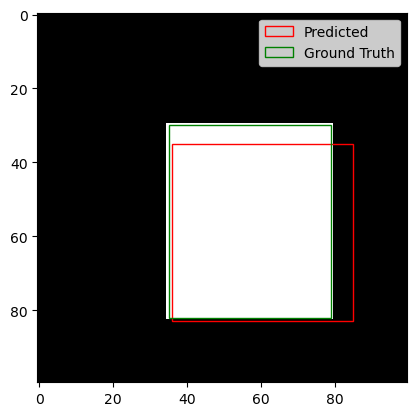

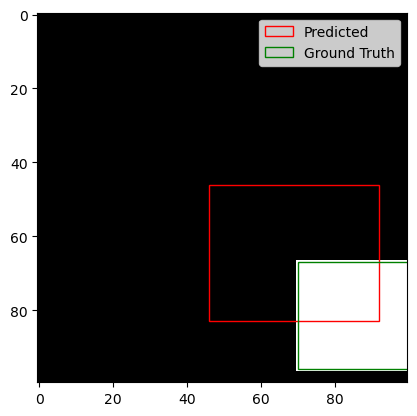

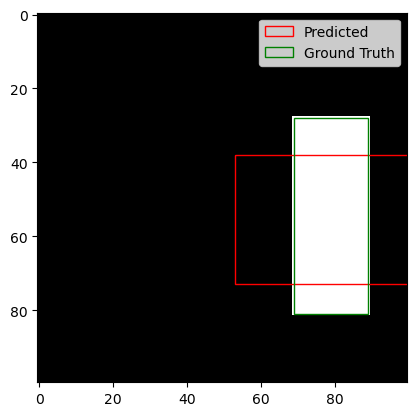

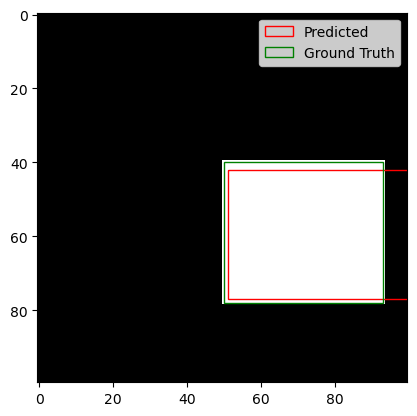

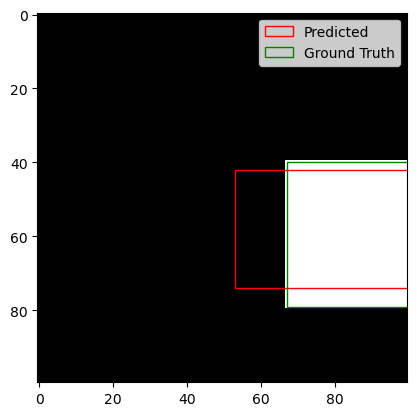

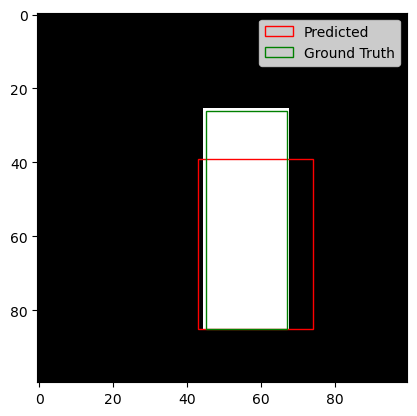

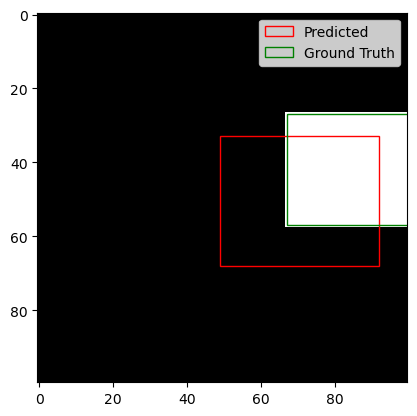

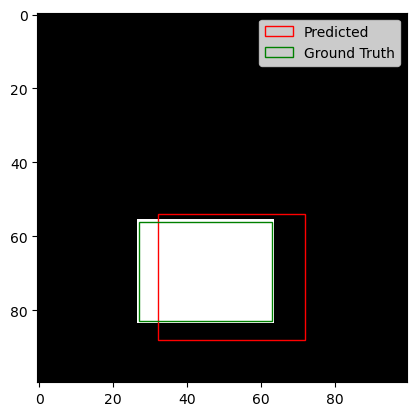

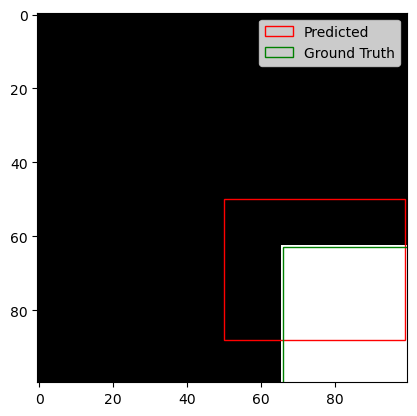

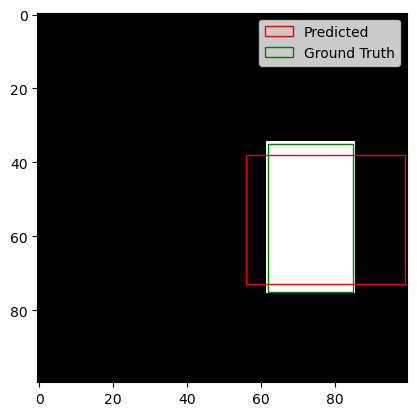

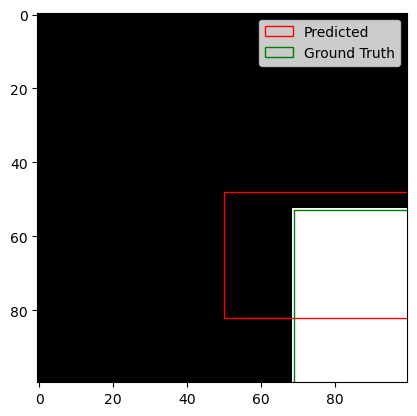

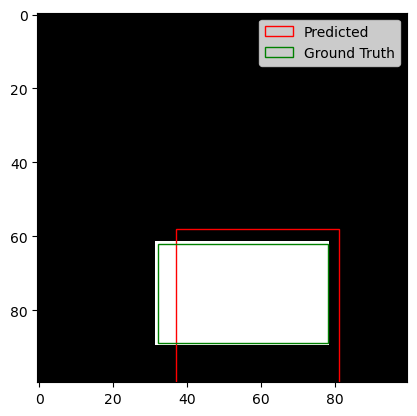

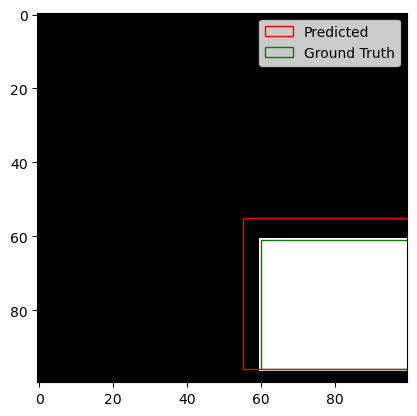

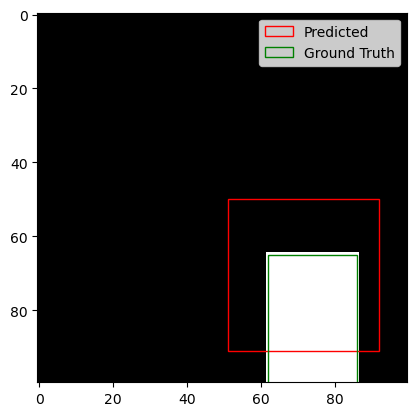

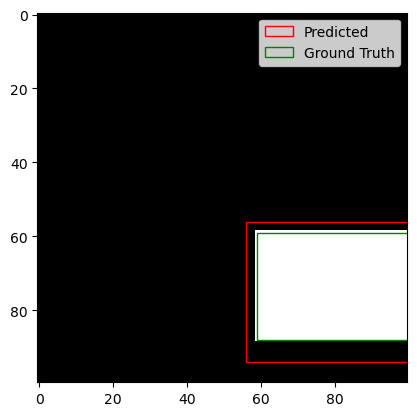

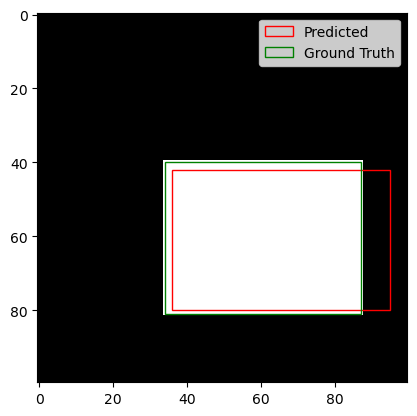

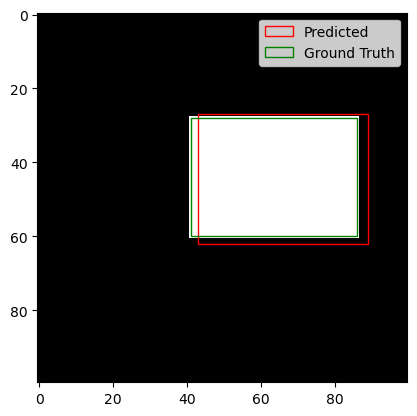

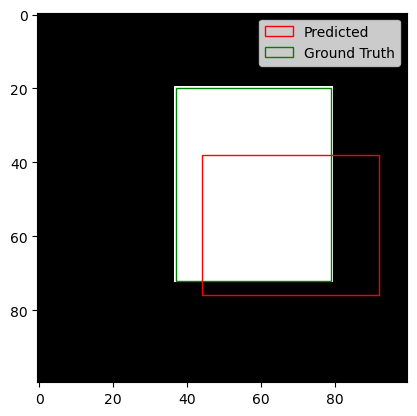

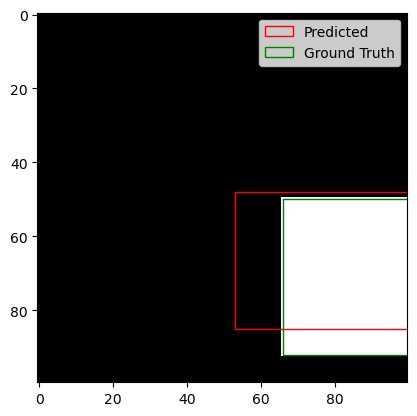

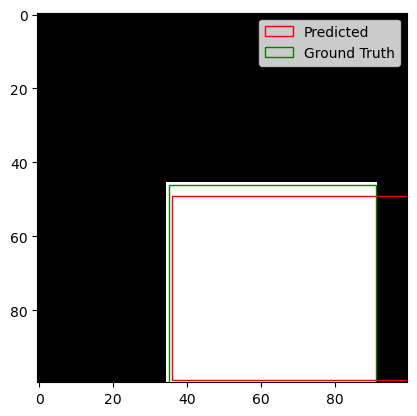

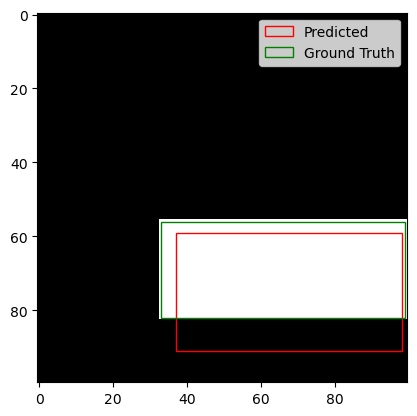

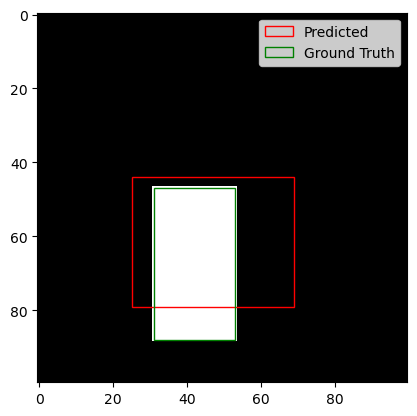

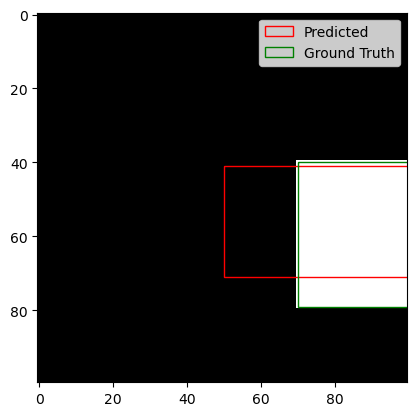

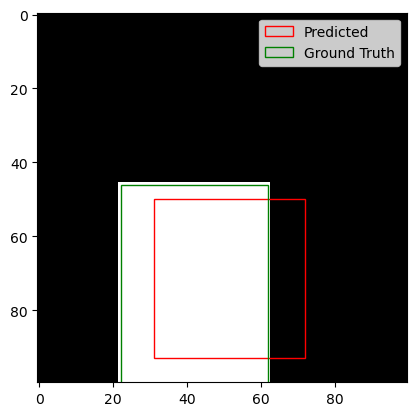

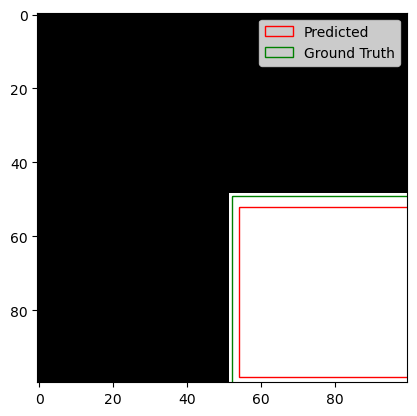

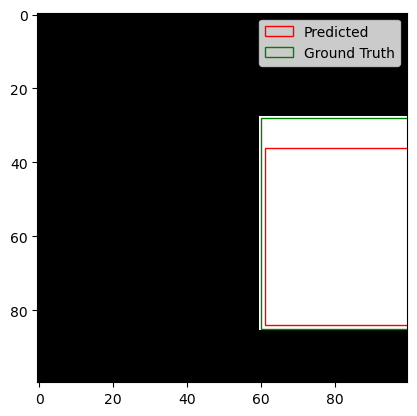

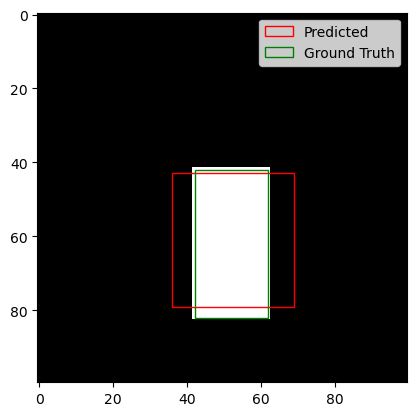

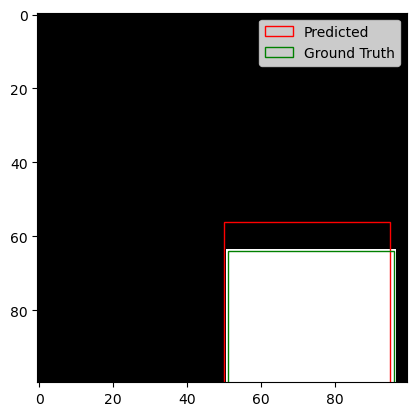

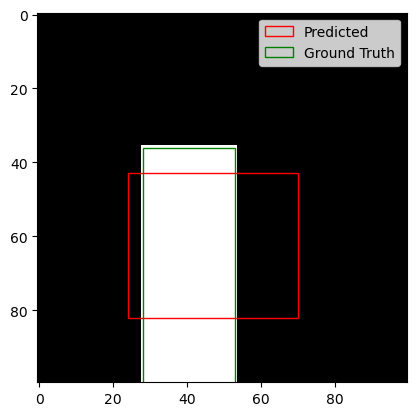

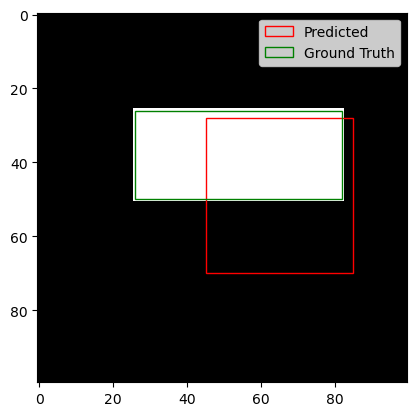

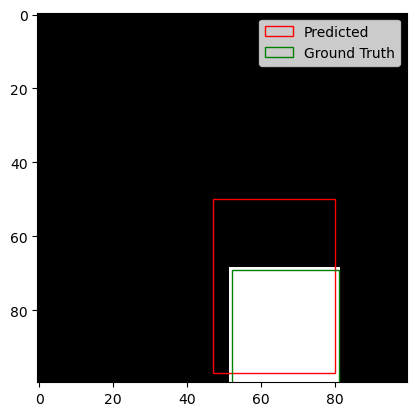

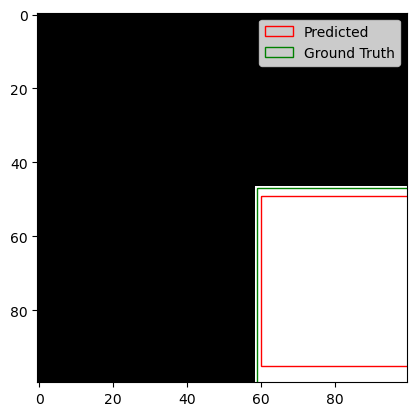

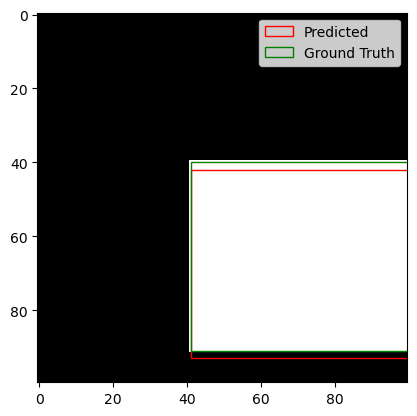

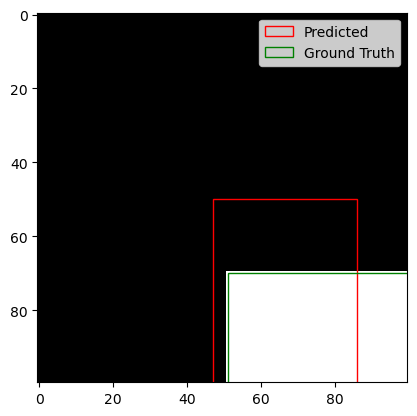

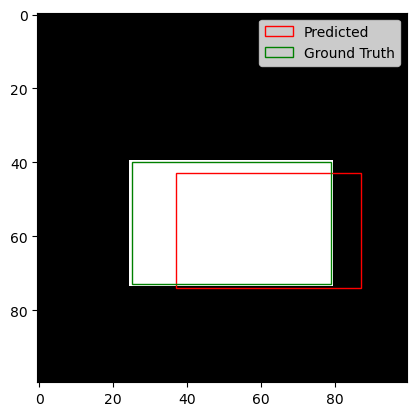

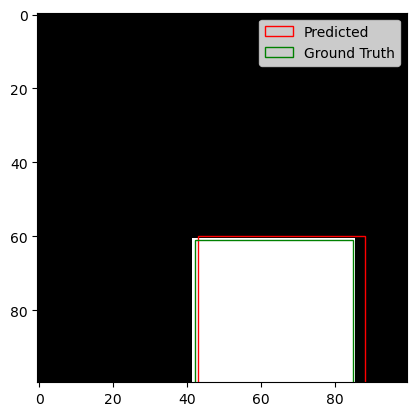

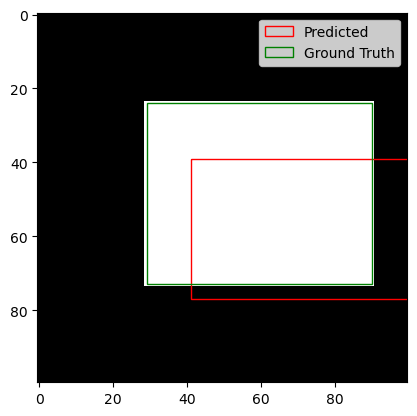

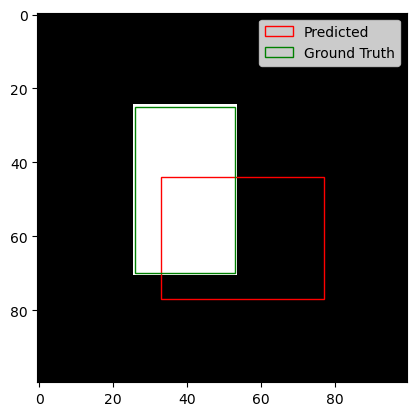

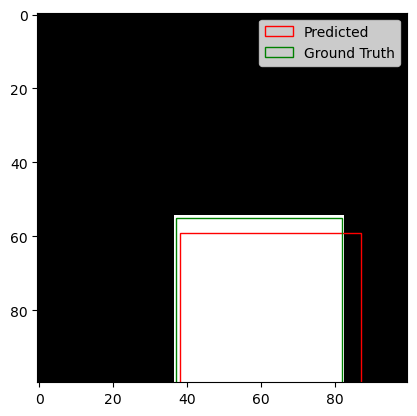

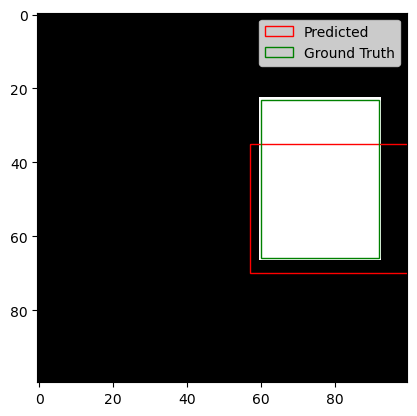

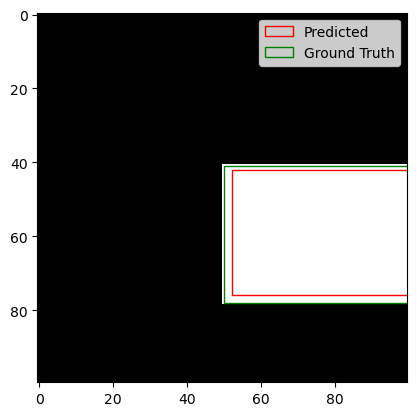

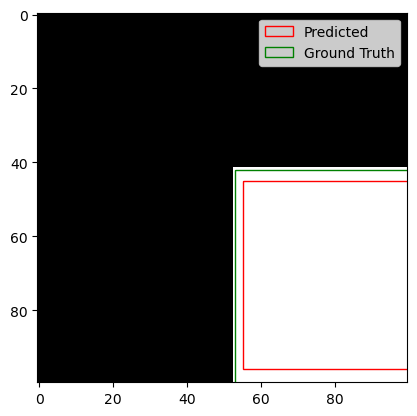

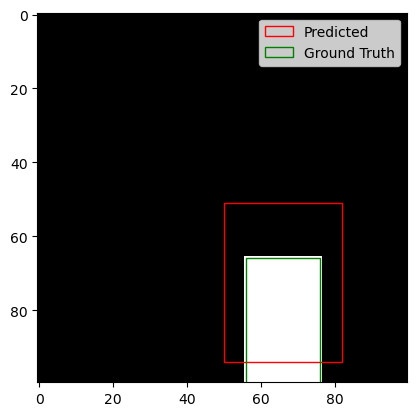

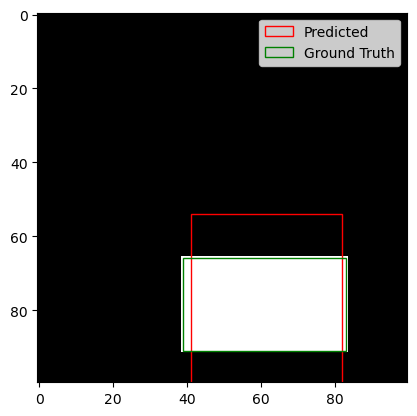

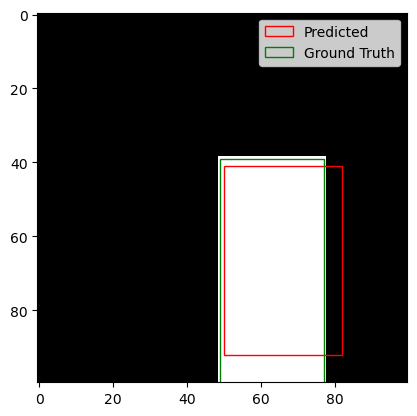

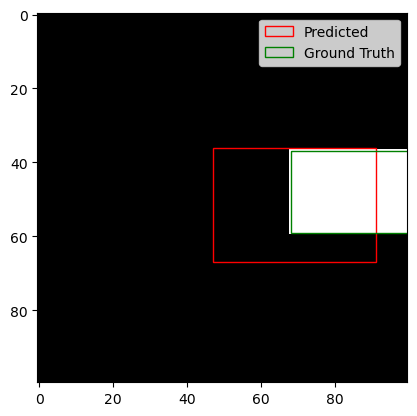

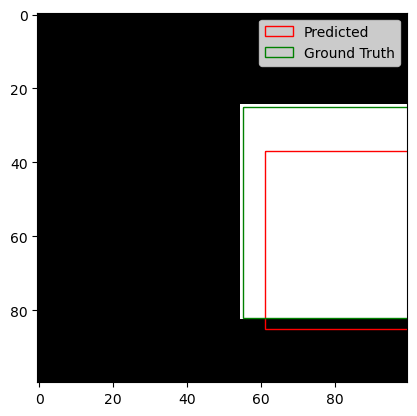

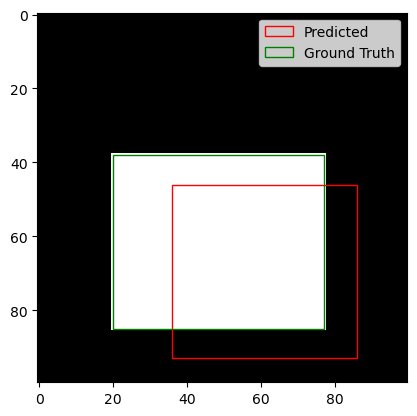

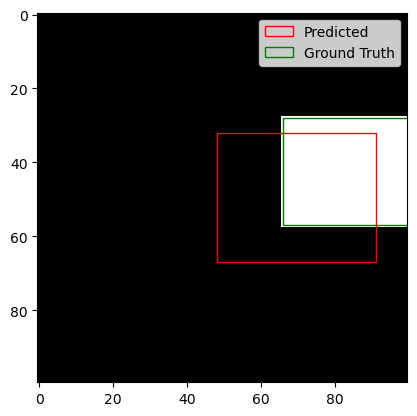

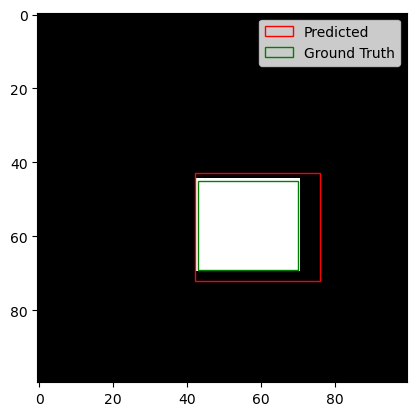

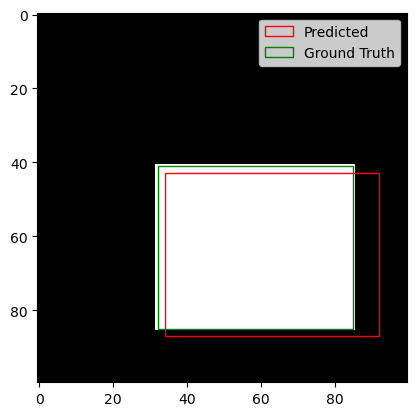

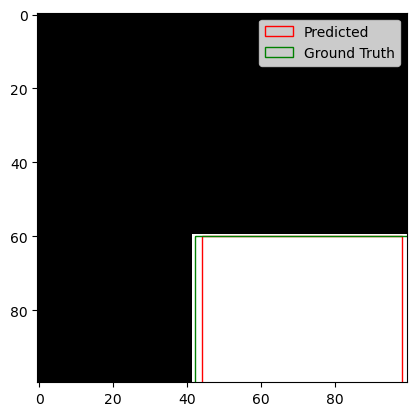

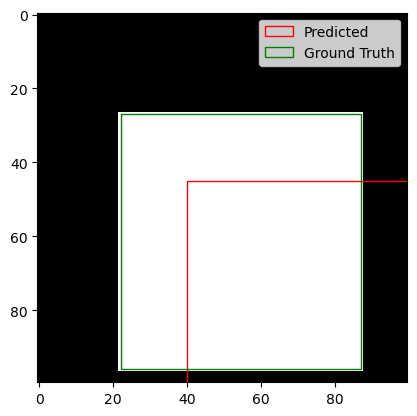

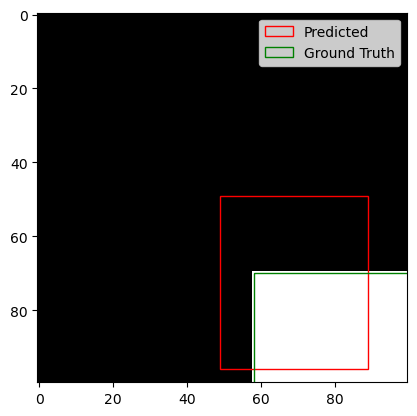

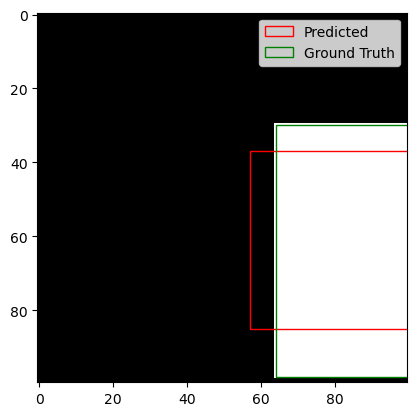

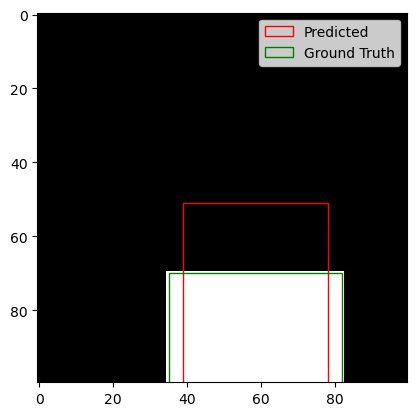

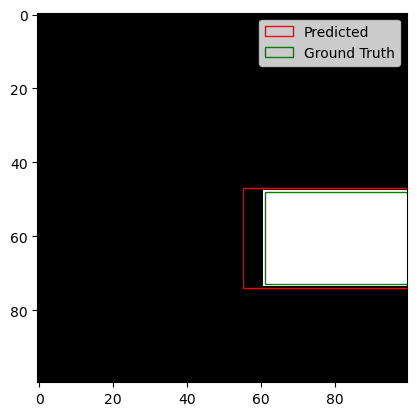

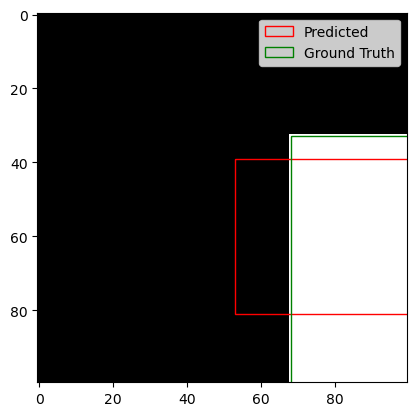

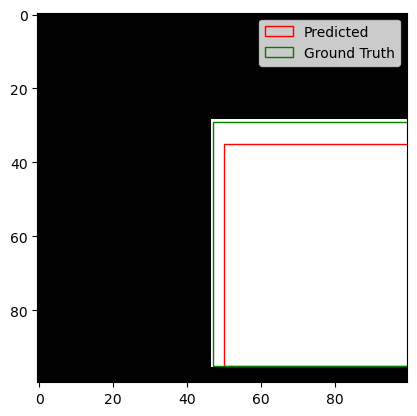

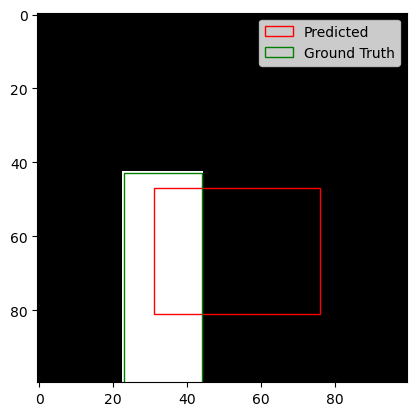

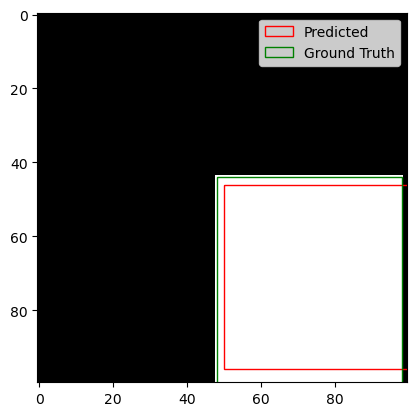

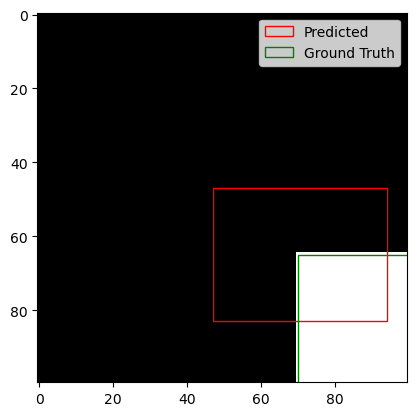

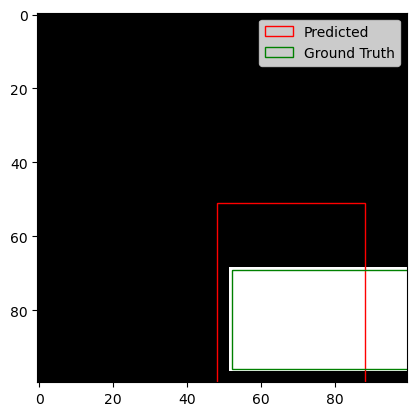

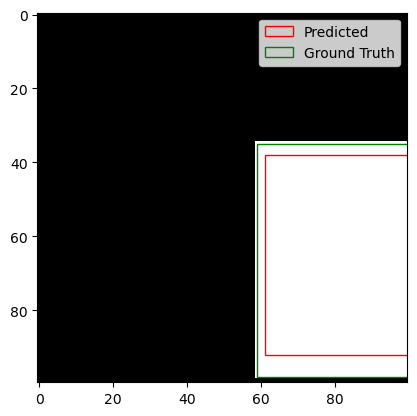

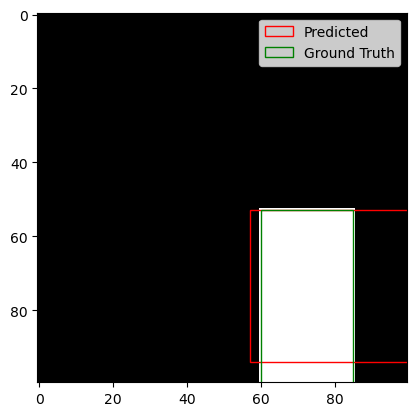

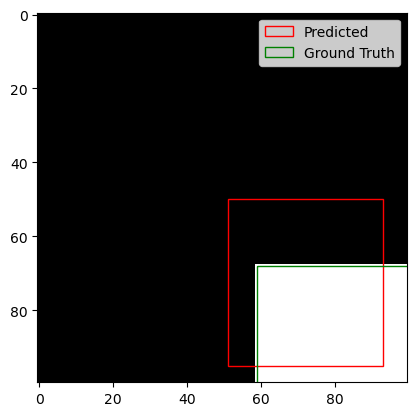

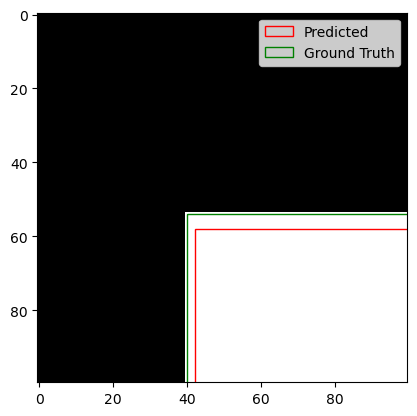

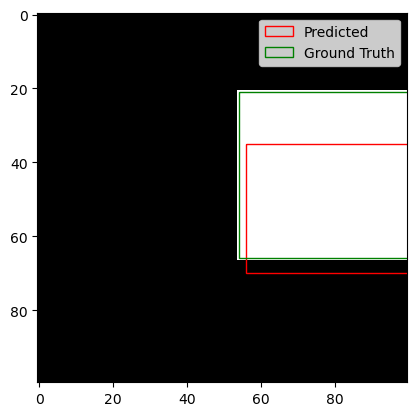

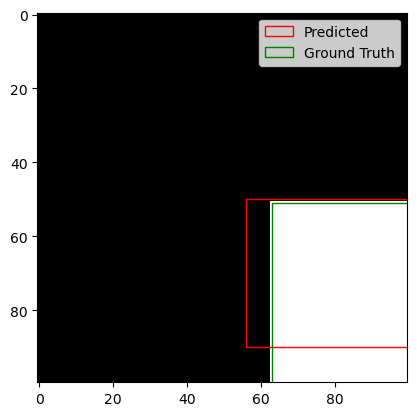

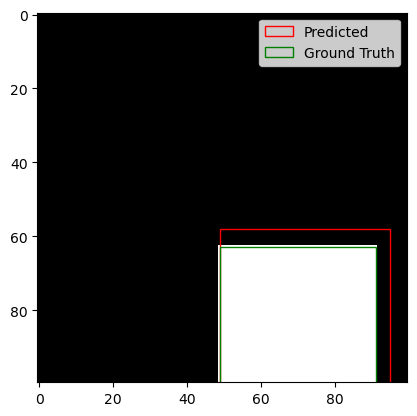

In [2]:
import numpy as np
import pandas as pd
from functions import overlapScore
import torch
from cnn_model import cnn_model
import matplotlib.pyplot as plt
import matplotlib.patches as patches

def main():
    testX = pd.read_csv('Dataset/testData.csv', sep=',', header=None)
    groundTruth = pd.read_csv('Dataset/ground-truth-test.csv', sep=',', header=None)

    testX = np.asanyarray(testX)
    groundTruth = np.asarray(groundTruth)
    groundTruth = np.asarray(groundTruth)


    model = cnn_model()
    model.eval()
    model.load_state_dict(torch.load('Model/cnn_model.pth'))


    output = model(torch.Tensor(np.reshape(testX, (len(testX),1,100,100))) / 255.0) * 100

    output = output.detach().numpy()
    output = output.astype(int)

    score, _ = overlapScore(output, groundTruth)
    score /= len(testX)
    print('Test Average overlap score : %f' % score)

    np.savetxt('Results/test-result.csv', output, delimiter=',')

    for i in range(len(testX)):
        img = testX[i].reshape(100, 100)
        fig, ax = plt.subplots()
        ax.imshow(img, cmap='gray')

        pred_box = output[i]
        pred_rect = patches.Rectangle((pred_box[0], pred_box[1]), pred_box[2], pred_box[3], linewidth=1, edgecolor='r', facecolor='none', label='Predicted')
        ax.add_patch(pred_rect)

        gt_box = groundTruth[i]
        gt_rect = patches.Rectangle((gt_box[0], gt_box[1]), gt_box[2], gt_box[3], linewidth=1, edgecolor='g', facecolor='none', label='Ground Truth')
        ax.add_patch(gt_rect)

        plt.legend()
        plt.show()

main()